# Imports

In [1]:
import sys
import math
import statistics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import *
from decimal import Decimal
from IPython.display import Image
from matplotlib import pyplot as plt

sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Quick Links

<ol>
    <li><a href=#find_motif>Motif Discovery</a></li>
    <li><a href=#score_dist>Score Distribution</a></li>
    <li><a href=#sig_snps>Significant SNPs</a></li>
    <li><a href=#neg_snps>Negative Scoring SNPs</a></li>
    <li><a href=#pos_snps>Positive Scoring SNPs</a></li>
    <li><a href=#final_table>Final SNP Table</a></li>
</ol>

## Choose Cluster

In [2]:
cluster_input = 21

# Prepare Scores

In [3]:
cluster = str(cluster_input)
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                +cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print()
print("Num effect sequences:", '\t', '\t', len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                    +cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                    +cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", '\t', len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                        +cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

print("Num scores:", '\t', '\t', '\t', len(noneffect_onehot))

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) \
                           for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'
                                         +cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) \
                             for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'
                                           +cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)


Num effect sequences: 	 	 681
Num noneffect sequences: 	 681
Num scores: 	 	 	 681


# Model the Distribution of Importance Scores <a name='find_motif' />

In [4]:
sig_list = []
ksvals = []
motifs = []
motif_others = []

for seq in range(len(effect_onehot)):
    if merged_ism_scores[seq] >= 0:
        scores = [np.sum(j) for j in merged_effect_scores[seq][400:600]]
    else:
        scores = [np.sum(j) for j in merged_noneffect_scores[seq][400:600]]
    shape, mean, stdev = t.fit(scores)
    kstat, kval = stats.kstest(scores, 't', args=[shape, mean, stdev])
    if merged_ism_scores[seq] >= 0:
        pvals = t.cdf([np.sum(j) for j in merged_effect_scores[seq]], shape, mean, stdev)
    else:
        pvals = t.cdf([np.sum(j) for j in merged_noneffect_scores[seq]], shape, mean, stdev)
    ksvals.append([kstat, kval])
    
    start = 499
    end = 499
    while True:
        if pvals[start - 1] <= 0.95:
            if pvals[start - 2] <= 0.95:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if pvals[end] <= 0.95:
            if pvals[end + 1] <= 0.95:
                break
            else:
                end += 1
        else:
            end += 1

    if merged_ism_scores[seq] >= 0:
        if start != end:
            motif = effect_seqs[seq][start:end]
            motif_other = noneffect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = effect_seqs[seq][mstart:mend]
                motif_other = noneffect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
        else:
            mstart = start - 4
            mend = end + 6
            motif = effect_seqs[seq][mstart:mend]
            motif_other = noneffect_seqs[seq][mstart:mend]
    else:
        if start != end:
            motif = noneffect_seqs[seq][start:end]
            motif_other = effect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = noneffect_seqs[seq][mstart:mend]
                motif_other = effect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
                
        else:
            mstart = start - 4
            mend = end + 6
            motif = noneffect_seqs[seq][mstart:mend]
            motif_other = effect_seqs[seq][mstart:mend]
    
    motifs.append(motif)
    motif_others.append(motif_other)
    sig_list.append([start, end, shape, mean, stdev, mstart, mend])

sig_list_stats = [x[1]-x[0] for x in sig_list if x[1]-x[0] != 0]
all_list_stats = [len(x) for x in motifs]
ksvals_pvals = [x[1] for x in ksvals]
sig_ksvals = [x for x in ksvals_pvals if x < 0.01]
print()
print('Mean KS-test p-value:', '\t', '\t', statistics.mean(ksvals_pvals))
print('Median KS-test p-value:', '\t', statistics.median(ksvals_pvals))
print('St. Dev KS-test p-value:', '\t', statistics.stdev(ksvals_pvals))
print('Max KS-test p-value:', '\t', '\t', max(ksvals_pvals))
print('Min KS-test p-value:', '\t', '\t', min(ksvals_pvals))
print('Num significant p-values:', '\t', len(sig_ksvals))
print()
print('Mean non-zero motif length:', '\t', statistics.mean(sig_list_stats))
print('Median non-zero motif length:', '\t', statistics.median(sig_list_stats))
print('St. Dev non-zero motif length:', '\t', statistics.stdev(sig_list_stats))
#print('Mode non-zero motif length:', '\t', statistics.mode(sig_list_stats))
print('Max non-zero motif length:', '\t', max(sig_list_stats))
print('Min non-zero motif lenght:', '\t', min(sig_list_stats))
print()
print('Mean motif length:', '\t', '\t', statistics.mean(all_list_stats))
print('Median motif length:', '\t', '\t', statistics.median(all_list_stats))
print('St. Dev motif length:', '\t', '\t', statistics.stdev(all_list_stats))
#print('Mode motif length:', '\t', '\t', statistics.mode(all_list_stats))
print('Max motif length:', '\t', '\t', max(all_list_stats))
print('Min motif lenght:', '\t', '\t', min(all_list_stats))


Mean KS-test p-value: 	 	 0.4501676511379365
Median KS-test p-value: 	 0.406923883216184
St. Dev KS-test p-value: 	 0.3186462147880519
Max KS-test p-value: 	 	 0.9996844146620829
Min KS-test p-value: 	 	 3.2793779308446618e-15
Num significant p-values: 	 43

Mean non-zero motif length: 	 8.673202614379084
Median non-zero motif length: 	 8.0
St. Dev non-zero motif length: 	 6.024355012463149
Max non-zero motif length: 	 26
Min non-zero motif lenght: 	 1

Mean motif length: 	 	 10.72834067547724
Median motif length: 	 	 10
St. Dev motif length: 	 	 2.6033753613347494
Max motif length: 	 	 26
Min motif lenght: 	 	 7


# Prepare DataFrame

In [5]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                   +cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/ld_buddies_table_stage3.tsv', sep='\t')

effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
orig_score = []
diff_score = []
ratio_score = []
ism_score = []
delta_score = []
idr_peak = []
gwas = []
gwas_pval = []
coloc = []

for index,row in snps.iterrows():
    
    orig_eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][475:525]]))
    eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    eff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                        for j in \
                                        merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    effect_center.append(eff_cent)
    
    orig_noneff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_noneffect_scores[index][475:525]]))
    noneff_cent = np.sum(np.array([np.sum(j) \
                                   for j in \
                                   merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                           for j in \
                                           merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneffect_center.append(noneff_cent)
    
    eff_bg = np.sum(np.array([max(0, np.sum(j)) \
                              for j in merged_effect_scores[index][400:600]]))
    eff_rat = eff_cent_nonzero / eff_bg
    effect_ratio.append(eff_rat)
    
    noneff_bg = np.sum(np.array([max(0, np.sum(j)) \
                                 for j in merged_noneffect_scores[index][400:600]]))
    noneff_rat = noneff_cent_nonzero / noneff_bg
    noneffect_ratio.append(noneff_rat)
    
    orig_score.append(orig_eff_cent - orig_noneff_cent)
    if (sig_list[index][1] - sig_list[index][0]) > 0:
        diff_score.append(eff_cent_nonzero - noneff_cent_nonzero)
        ratio_score.append(eff_rat - noneff_rat)
    else:
        diff_score.append('NAN')
        ratio_score.append('NAN')
    
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    lowest_pval = 1
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        if rw['has_coloc'] == True:
            has_coloc = True
        if rw['pvalue'] < lowest_pval:
            gwas_list = rw['source_gwas']
            lowest_pval = rw['pvalue']
    gwas.append(gwas_list)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)

snps.effect.replace('NAN', 'Z', inplace=True)
snps.noneffect.replace('NAN', 'Z', inplace=True)
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['orig_score'] = orig_score
snps['diff_score'] = diff_score
snps['ratio_score'] = ratio_score
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['gwas'] = gwas
snps['gwas_pval'] = gwas_pval
snps['coloc'] = coloc
snps['idr_peak'] = idr_peak
snps['motif'] = motifs
snps['motif_other'] = motif_others
snps.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
snps.sort_values(by=['rsid', 'effect'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)
snps.effect.replace('Z', 'NAN', inplace=True)
snps.noneffect.replace('Z', 'NAN', inplace=True)
print()
print('Number of Unique SNPs:', len(snps))

/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Number of Unique SNPs: 605


## Distribution of Original gkmExplain Scores <a name='score_dist' />


Number of SNPs with significant motifs: 605


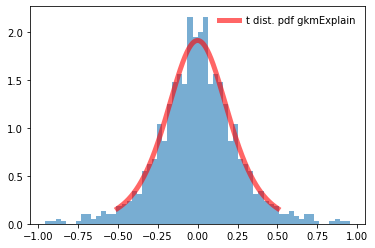

In [6]:
true_orig_scores = snps.orig_score.tolist()
true_orig_scores = [i for i in true_orig_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_orig_scores))
oppo_orig_scores = [-1 * i for i in true_orig_scores]
orig_scores = true_orig_scores + oppo_orig_scores
orig_shape, orig_mean, orig_stdev = t.fit(orig_scores)
fig, ax = plt.subplots(1, 1)
orig_x = np.linspace(t.ppf(0.025, orig_shape, orig_mean, orig_stdev),
                t.ppf(0.975, orig_shape, orig_mean, orig_stdev), 1000)
ax.plot(orig_x, t.pdf(orig_x, orig_shape, orig_mean, orig_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(orig_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Original gkmExplain Scores

In [7]:
print()
print('Shape:', '\t', orig_shape)
print('Mean:', '\t', orig_mean)
print('Stdev:', '\t', orig_stdev)
print()
print(stats.kstest(orig_scores, 't', args=[orig_shape, orig_mean, orig_stdev]))


Shape: 	 5.322593094938382
Mean: 	 -2.7978898466274485e-07
Stdev: 	 0.19909397058886516

KstestResult(statistic=0.01573849587508186, pvalue=0.9253405090135186)


## Distribution of Non-Zero Difference gkmExplain Scores


Number of SNPs with significant motifs: 269


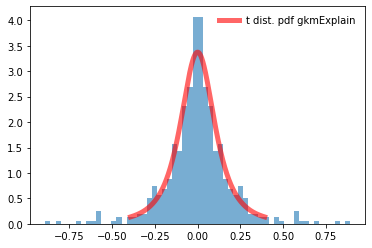

In [8]:
true_diff_scores = snps.diff_score.tolist()
true_diff_scores = [i for i in true_diff_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_diff_scores))
oppo_diff_scores = [-1 * i for i in true_diff_scores]
diff_scores = true_diff_scores + oppo_diff_scores
diff_shape, diff_mean, diff_stdev = t.fit(diff_scores)
fig, ax = plt.subplots(1, 1)
diff_x = np.linspace(t.ppf(0.025, diff_shape, diff_mean, diff_stdev),
                t.ppf(0.975, diff_shape, diff_mean, diff_stdev), 1000)
ax.plot(diff_x, t.pdf(diff_x, diff_shape, diff_mean, diff_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(diff_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Non-Zero Difference gkmExplain Scores

In [9]:
print()
print('Shape:', '\t', diff_shape)
print('Mean:', '\t', diff_mean)
print('Stdev:', '\t', diff_stdev)
print()
print(stats.kstest(diff_scores, 't', args=[diff_shape, diff_mean, diff_stdev]))


Shape: 	 2.4070761814723696
Mean: 	 -3.1582249680761334e-07
Stdev: 	 0.1068329331045453

KstestResult(statistic=0.02592010043180165, pvalue=0.862673554507988)


## Distribution of Ratio Difference gkmExplain Scores


Number of SNPs with significant motifs: 269


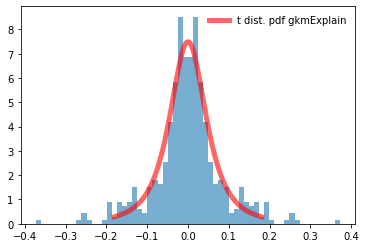

In [10]:
true_ratio_scores = snps.ratio_score.tolist()
true_ratio_scores = [i for i in true_ratio_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_ratio_scores))
oppo_ratio_scores = [-1 * i for i in true_ratio_scores]
ratio_scores = true_ratio_scores + oppo_ratio_scores
ratio_shape, ratio_mean, ratio_stdev = t.fit(ratio_scores)
fig, ax = plt.subplots(1, 1)
ratio_x = np.linspace(t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev),
                t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev), 1000)
ax.plot(ratio_x, t.pdf(ratio_x, ratio_shape, ratio_mean, ratio_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(ratio_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Ratio Difference gkmExplain Scores

In [11]:
print()
print('Shape:', '\t', ratio_shape)
print('Mean:', '\t', ratio_mean)
print('Stdev:', '\t', ratio_stdev)
print()
print(stats.kstest(ratio_scores, 't', args=[ratio_shape, ratio_mean, ratio_stdev]))


Shape: 	 2.328839948629909
Mean: 	 1.1760513450477002e-07
Stdev: 	 0.04797285956699894

KstestResult(statistic=0.027579077348483305, pvalue=0.8077884914754221)


## Distribution of ISM Scores

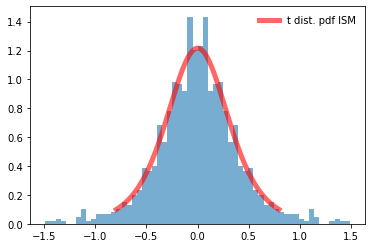

In [12]:
true_ism_scores = snps.ism_score.tolist()
oppo_ism_scores = [-1 * i for i in true_ism_scores]
ism_scores = true_ism_scores + oppo_ism_scores
ism_shape, ism_mean, ism_stdev = t.fit(ism_scores)
fig, ax = plt.subplots(1, 1)
ism_x = np.linspace(t.ppf(0.025, ism_shape, ism_mean, ism_stdev),
                t.ppf(0.975, ism_shape, ism_mean, ism_stdev), 1000)
ax.plot(ism_x, t.pdf(ism_x, ism_shape, ism_mean, ism_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf ISM')
ax.hist(ism_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for ISM Scores

In [13]:
print()
print('Shape:', '\t', ism_shape)
print('Mean:', '\t', ism_mean)
print('Stdev:', '\t', ism_stdev)
print()
print(stats.kstest(ism_scores, 't', args=[ism_shape, ism_mean, ism_stdev]))


Shape: 	 5.204792769800354
Mean: 	 -1.638593811738953e-08
Stdev: 	 0.31272010109718984

KstestResult(statistic=0.013874344154256202, pvalue=0.9739871147125911)


## Distribution of Delta Scores

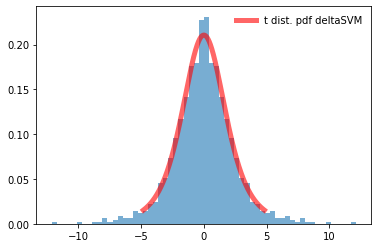

In [14]:
true_delta_scores = snps.delta_score.tolist()
oppo_delta_scores = [-1 * i for i in true_delta_scores]
delta_scores = true_delta_scores + oppo_delta_scores
delta_shape, delta_mean, delta_stdev = t.fit(delta_scores)
fig, ax = plt.subplots(1, 1)
delta_x = np.linspace(t.ppf(0.025, delta_shape, delta_mean, delta_stdev),
                t.ppf(0.975, delta_shape, delta_mean, delta_stdev), 1000)
ax.plot(delta_x, t.pdf(delta_x, delta_shape, delta_mean, delta_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf deltaSVM')
ax.hist(delta_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Delta Scores

In [15]:
print()
print('Shape:', '\t', delta_shape)
print('Mean:', '\t', delta_mean)
print('Stdev:', '\t', delta_stdev)
print()
print(stats.kstest(delta_scores, 't', args=[delta_shape, delta_mean, delta_stdev]))


Shape: 	 4.3228585957906684
Mean: 	 -5.368017513309817e-06
Stdev: 	 1.7880357668432483

KstestResult(statistic=0.014157024628921655, pvalue=0.9685678398211894)


# Get Significant SNPs

In [16]:
pd.set_option('mode.chained_assignment', None)

snps.orig_score.replace('NAN', 0.0, inplace=True)
snps.diff_score.replace('NAN', 0.0, inplace=True)
snps.ratio_score.replace('NAN', 0.0, inplace=True)

orig_pval = [2 * min(t.cdf(x, orig_shape, orig_mean, orig_stdev),
                        1 - t.cdf(x, orig_shape, orig_mean, orig_stdev)) \
                for x in snps['orig_score']]

diff_pval = [2 * min(t.cdf(x, diff_shape, diff_mean, diff_stdev),
                        1 - t.cdf(x, diff_shape, diff_mean, diff_stdev)) \
                for x in snps['diff_score']]

ratio_pval = [2 * min(t.cdf(x, ratio_shape, ratio_mean, ratio_stdev),
                        1 - t.cdf(x, ratio_shape, ratio_mean, ratio_stdev)) \
                for x in snps['ratio_score']]

ism_pval = [2 * min(t.cdf(x, ism_shape, ism_mean, ism_stdev),
                1 - t.cdf(x, ism_shape, ism_mean, ism_stdev)) \
            for x in snps['ism_score']]

delta_pval = [2 * min(t.cdf(x, delta_shape, delta_mean, delta_stdev),
                1 - t.cdf(x, delta_shape, delta_mean, delta_stdev)) \
            for x in snps['delta_score']]

kstest_pval = [ksvals_pvals[x] for x in snps.index]

snps['orig_pval'] = orig_pval
snps['diff_pval'] = diff_pval
snps['ratio_pval'] = ratio_pval
snps['ism_pval'] = ism_pval
snps['delta_pval'] = delta_pval
snps['kstest_pval'] = kstest_pval

neg_orig_cutoff = t.ppf(0.025, orig_shape, orig_mean, orig_stdev)
neg_diff_cutoff = t.ppf(0.025, diff_shape, diff_mean, diff_stdev)
neg_ratio_cutoff_low = t.ppf(0.1, ratio_shape, ratio_mean, ratio_stdev)
neg_ratio_cutoff_high = t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev)
neg_ism_cutoff = t.ppf(0.025, ism_shape, ism_mean, ism_stdev)
neg_delta_cutoff = t.ppf(0.025, delta_shape, delta_mean, delta_stdev)

snps.sort_values(by=['ratio_pval'], ascending=True, inplace=True)
neg_snps = snps.loc[(snps['orig_score'] < neg_orig_cutoff)
                    & (snps['ism_score'] < neg_ism_cutoff)
                    & (snps['delta_score'] < neg_delta_cutoff)]

pos_orig_cutoff = t.ppf(0.975, orig_shape, orig_mean, orig_stdev)
pos_diff_cutoff = t.ppf(0.975, diff_shape, diff_mean, diff_stdev)
pos_ratio_cutoff_low = t.ppf(0.9, ratio_shape, ratio_mean, ratio_stdev)
pos_ratio_cutoff_high = t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev)
pos_ism_cutoff = t.ppf(0.975, ism_shape, ism_mean, ism_stdev)
pos_delta_cutoff = t.ppf(0.975, delta_shape, delta_mean, delta_stdev)

pos_snps = snps.loc[(snps['orig_score'] > pos_orig_cutoff)
                    & (snps['ism_score'] > pos_ism_cutoff)
                    & (snps['delta_score'] > pos_delta_cutoff)]

neg_confidence = [0 for x in range(len(neg_snps))]
pos_confidence = [0 for x in range(len(pos_snps))]

counter = 0
for index, row in neg_snps.iterrows():
    if (row['ratio_score'] < neg_ratio_cutoff_high):
        neg_confidence[counter] = 2
    elif (row['ratio_score'] < neg_ratio_cutoff_low) or (row['diff_score'] < neg_diff_cutoff):
        neg_confidence[counter] = 1
    counter += 1
    
counter = 0
for index, row in pos_snps.iterrows():
    if (row['ratio_score'] > pos_ratio_cutoff_high):
        pos_confidence[counter] = 2
    elif (row['ratio_score'] > pos_ratio_cutoff_low) or (row['diff_score'] > pos_diff_cutoff):
        pos_confidence[counter] = 1
    counter += 1
    
neg_snps['confidence'] = neg_confidence
pos_snps['confidence'] = pos_confidence

# Display Significant SNPs <a name='sig_snps' />

In [17]:
print()
print('Negative Original gkmExplain Cutoff:', '\t', '\t', '\t', neg_orig_cutoff)
print('Negative Non-Zero Difference gkmExplain Cutoff:', '\t', neg_diff_cutoff)
print('Negative Ratio Difference gkmExplain Low Cutoff:', '\t', neg_ratio_cutoff_low)
print('Negative Ratio Difference gkmExplain High Cutoff:', '\t', neg_ratio_cutoff_high)
print('Negative ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', neg_ism_cutoff)
print('Negative deltaSVM Cutoff:', '\t', '\t', '\t', '\t', neg_delta_cutoff)
print()
print('Total SNPs with Negative Scores:', '\t', '\t', '\t', len(neg_snps))
print('Confident SNPs with Negative Scores:', '\t', '\t', '\t', len([i for i in neg_confidence if i > 0]))
print('Highly Confident SNPs with Negative Scores:', '\t', '\t', len([i for i in neg_confidence if i > 1]))
display(neg_snps)

print()
print('Positive Original gkmExplain Cutoff:', '\t', '\t', '\t', pos_orig_cutoff)
print('Positive Non-Zero Difference gkmExplain Cutoff:', '\t', pos_diff_cutoff)
print('Positive Ratio Difference gkmExplain Low Cutoff:', '\t', pos_ratio_cutoff_low)
print('Positive Ratio Difference gkmExplain High Cutoff:', '\t', pos_ratio_cutoff_high)
print('Positive ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', pos_ism_cutoff)
print('Positive deltaSVM Cutoff:', '\t', '\t', '\t', '\t', pos_delta_cutoff)
print()
print('Total SNPs with Positive Scores:', '\t', '\t', '\t', len(pos_snps))
print('Confident SNPs with Positive Scores:', '\t', '\t', '\t', len([i for i in pos_confidence if i > 0]))
print('Highly Confident SNPs with Positive Scores:', '\t', '\t', len([i for i in pos_confidence if i > 1]))
display(pos_snps)


Negative Original gkmExplain Cutoff: 	 	 	 -0.5025971954965579
Negative Non-Zero Difference gkmExplain Cutoff: 	 -0.3926483973286017
Negative Ratio Difference gkmExplain Low Cutoff: 	 -0.08509247598606372
Negative Ratio Difference gkmExplain High Cutoff: 	 -0.18084863842002538
Negative ISM Cutoff: 	 	 	 	 	 -0.7944515819793093
Negative deltaSVM Cutoff: 	 	 	 	 -4.821527309117766

Total SNPs with Negative Scores: 	 	 	 16
Confident SNPs with Negative Scores: 	 	 	 11
Highly Confident SNPs with Negative Scores: 	 	 4


chr      start        end         rsid effect noneffect ref  alt major  \
503   chr2  127128581  127128582   rs13025717      T         C   C    T     C   
643   chr6   27772520   27772521     rs760587      C         A   C    A     C   
128  chr17    4901871    4901872   rs79436576      T         C   C    T     C   
196  chr17   45848599   45848600   rs62054817      G         A   G    A     G   
173  chr17   45783750   45783751   rs62057073      T         C   C    T     C   
423  chr19   44890258   44890259  rs117310449      T         C   C    T     C   
56   chr11   86103987   86103988    rs1237999      A         G   G    A     A   
528   chr3   49007333   49007334    rs6781790      T         C   C    T     T   
467  chr19   45326535   45326536     rs344791      C         G   G    C     C   
381  chr17   78426790   78426791   rs72914885      C         A   A    C     A   
405  chr19   18462023   18462024    rs8103622      T         C   C    T     C   
636   chr5  103120549  103120550      rs26523      T         C   C    T     C   
283  chr17   45977229   45977230   rs17572495      T         G   T    G     T   
370  chr17   75032747   75032748    rs7218004      A         G   G    A     G   
228  chr17   45895754   45895755  rs111972148      G         C   G  C,T     G   
216  chr17   45882956   45882957   rs56365901      G         A   A    G     A   

    minor direction  locus_num  effect_center  noneffect_center  effect_ratio  \
503     T         +         77       0.275672          0.853863      0.244952   
643     A         -        110       0.372754          0.986164      0.201292   
128     T         +         55       0.180277          1.021165      0.062465   
196     A         +         54       0.743573          1.633782      0.471134   
173     T         -         54       0.129564          0.599392      0.073867   
423     T         +         71      -0.011859          0.348277      0.122726   
56      G         +         16      -0.023856          0.542535      0.036525   
528     C         +         92       0.455919          1.031675      0.194826   
467     G         -         71       0.018833          0.287790      0.271231   
381     C         -         62      -0.013705          0.323597      0.027706   
405     T         +         69       1.880597          2.471551      0.623255   
636     T         -        104      -0.020676          0.052293      0.000000   
283     G         +         54      -0.020742          0.046733      0.000000   
370     A         +         61      -0.039023          0.030891      0.000000   
228   C,T         +         54       0.000000          0.000000      0.000000   
216     G         -         54       0.000000          0.000000      0.000000   

     noneffect_ratio  orig_score  diff_score  ratio_score  ism_score  \
503         0.494198   -0.558458   -0.578191    -0.249246  -0.870688   
643         0.400128   -0.617307   -0.613411    -0.198837  -0.969784   
128         0.254493   -0.869904   -0.821626    -0.192028  -1.361795   
196         0.661345   -0.892088   -0.890209    -0.190211  -1.405706   
173         0.240543   -0.526785   -0.451207    -0.166676  -0.809214   
423         0.284686   -0.589690   -0.239698    -0.161960  -0.936577   
56          0.188454   -0.710026   -0.455977    -0.151929  -1.106467   
528         0.341034   -0.695762   -0.575756    -0.146208  -1.096082   
467         0.392802   -0.643864   -0.146677    -0.121571  -1.027442   
381         0.117953   -0.571295   -0.260758    -0.090247  -0.884050   
405         0.684283   -0.593200   -0.590954    -0.061028  -0.974957   
636         0.027301   -0.572311   -0.052293    -0.027301  -0.893965   
283         0.019599   -0.530200   -0.046733    -0.019599  -0.833070   
370         0.014740   -0.624168   -0.030891    -0.014740  -0.974564   
228         0.000000   -0.602483    0.000000     0.000000  -0.918508   
216         0.000000   -0.761802    0.000000     0.000000  -1.170096   

     delta_score          


Positive Original gkmExplain Cutoff: 	 	 	 0.5025966359185886
Positive Non-Zero Difference gkmExplain Cutoff: 	 0.3926477656836078
Positive Ratio Difference gkmExplain Low Cutoff: 	 0.08509271119633274
Positive Ratio Difference gkmExplain High Cutoff: 	 0.18084887363029434
Positive ISM Cutoff: 	 	 	 	 	 0.7944515492074329
Positive deltaSVM Cutoff: 	 	 	 	 4.8215165730827385

Total SNPs with Positive Scores: 	 	 	 15
Confident SNPs with Positive Scores: 	 	 	 7
Highly Confident SNPs with Positive Scores: 	 	 3


chr      start        end         rsid effect noneffect ref    alt  \
204  chr17   45852666   45852667   rs62054825      G         A   G      A   
471   chr2   95074354   95074355    rs7585473      T         G   T      G   
360  chr17   46771150   46771151     rs199523      C         A   C      A   
234  chr17   45897109   45897110   rs80346216      T         G   G      T   
500   chr2  127117812  127117813    rs3845674      T         G   T    C,G   
377  chr17   78414789   78414790    rs3744216      G         A   G    A,C   
175  chr17   45825432   45825433    rs3885075      G         A   A    C,G   
294  chr17   46003041   46003042  17_46003042      G         C   .      .   
534   chr3   52307781   52307782  rs149776414      G         A   G    A,T   
668   chr8   22604860   22604861    rs3735901      T         C   T      C   
259  chr17   45940574   45940575   rs62061732      T         G   G      T   
476   chr2   95297493   95297494    rs2248415      G         C   C  A,G,T   
437  chr19   44915228   44915229   rs12691088      A         G   G    A,C   
197  chr17   45848689   45848690   rs62054818      C         A   A      C   
316  chr17   46059822   46059823   rs55714296      T         A   A      T   

    major  minor direction  locus_num  effect_center  noneffect_center  \
204     G      A         +         54       0.762668          0.097890   
471     G      T         -         85       0.484928         -0.157980   
360     A      C         -         54       1.135096          0.397996   
234     G      T         -         54       0.984373          0.406519   
500     G    T,C         -         77       0.210709         -0.049165   
377     A    G,C         -         62       0.222027         -0.244276   
175     A    C,G         -         54       0.134216         -0.093606   
294     .      .         +         54       0.026441         -0.057252   
534     G    A,T         -         93       0.041213         -0.044761   
668     T      C         -        125       0.039953         -0.053325   
259     G      T         -         54       0.000000          0.000000   
476     G  C,A,T         +         85       0.000000          0.000000   
437     G    A,C         +         71       0.000000          0.000000   
197     A      C         -         54       0.000000          0.000000   
316     A      T         -         54       0.000000          0.000000   

     effect_ratio  noneffect_ratio  orig_score  diff_score  ratio_score  \
204      0.579928         0.206944    0.726648    0.630215     0.372984   
471      0.255068         0.000000    0.952735    0.484928     0.255068   
360      0.407085         0.210951    0.825898    0.696939     0.196134   
234      0.371884         0.205637    0.669061    0.577854     0.166247   
500      0.145427         0.011754    0.550062    0.197700     0.133673   
377      0.125881         0.000000    0.860431    0.222027     0.125881   
175      0.087756         0.000000    0.535985    0.134216     0.087756   
294      0.035827         0.000000    0.658245    0.026441     0.035827   
534      0.026985         0.000000    0.677597    0.041213     0.026985   
668      0.022979         0.000000    0.699758    0.039953     0.022979   
259      0.000000         0.000000    0.613288    0.000000     0.000000   
476      0.000000         0.000000    0.726313    0.000000     0.000000   
437      0.000000         0.000000    0.685900    0.000000     0.000000   
197      0.000000         0.000000    0.592286    0.000000     0.000000   
316      0.000000         0.000000    0.560388    0.000000     0.000000   

     ism_score  delta_score                      gwas      gwas_pval  coloc  \
204   1.137659     6.477922           23andme_PD_hg38   1.247000e-22   True   
471   1.486779     8.517345             Nalls_23andMe   3.673230e-02  False   
360   1.311138     7.577617           23andme_PD_hg38   9.492900e-14   True   
234   1.045238     5.971154           23andme_PD_hg38   3.938720e-22   T

# Visualize Top Negative Scoring SNPs <a name='neg_snps' />


Index: 503

RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 77   ||    IDR Peak: False

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 9.1258E-17   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.8539   ||   Center / 200bp : 0.4942

Noneffect Motif: GCCCCGCCCAAT


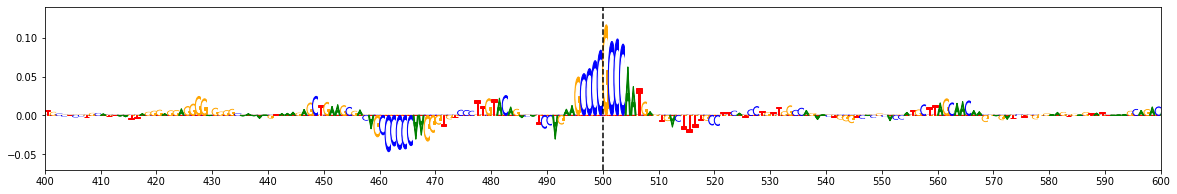

Effect Allele: T   ||   Effect Center: 0.2757   ||   Center / 200bp : 0.245

Effect Motif: GCCCTGCCCAAT


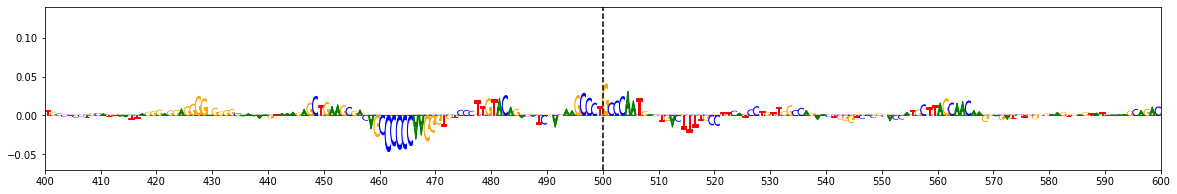

gkmExplain Score: -0.2492  ||  ISM Score: -0.8707  ||  deltaSVM Score: -4.8882

gkmExplain P-Value: 0.025211  ||  ISM P-Value: 0.03705  ||  deltaSVM P-Value: 0.048012

Difference Motif: GCCC(C/T)GCCCAAT


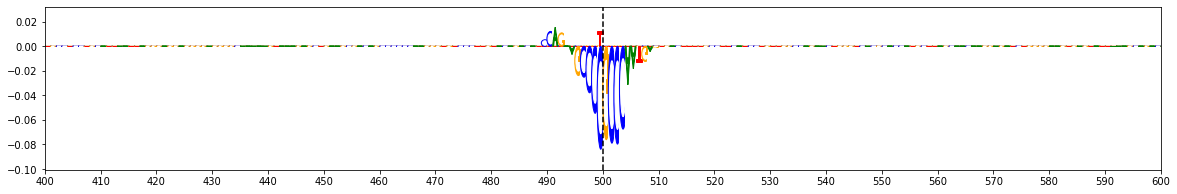



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 643

RSID: rs760587   ||    chr6 : 27772520 - 27772521   ||    Locus: 110   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 6.4367E-06   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: A   ||   Noneffect Center: 0.9862   ||   Center / 200bp : 0.4001

Noneffect Motif: GCAGCAAACAAAGGC


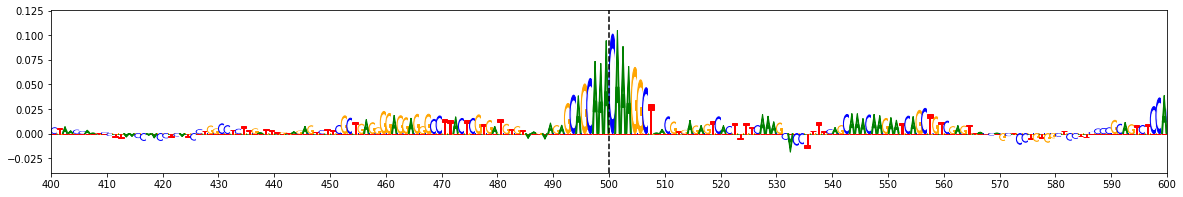

Effect Allele: C   ||   Effect Center: 0.3728   ||   Center / 200bp : 0.2013

Effect Motif: GCAGCAACCAAAGGC


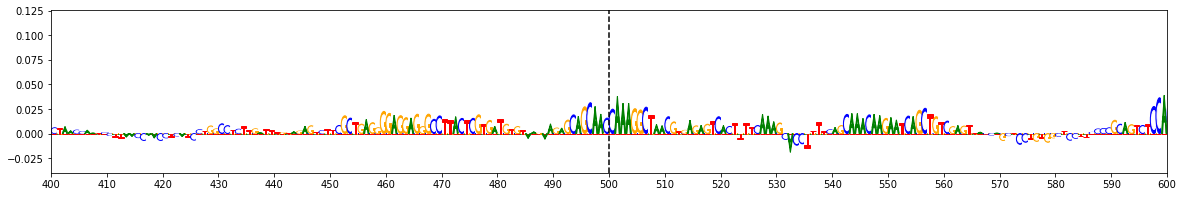

gkmExplain Score: -0.1988  ||  ISM Score: -0.9698  ||  deltaSVM Score: -5.5313

gkmExplain P-Value: 0.040996  ||  ISM P-Value: 0.025425  ||  deltaSVM P-Value: 0.032847

Difference Motif: GCAGCAA(A/C)CAAAGGC


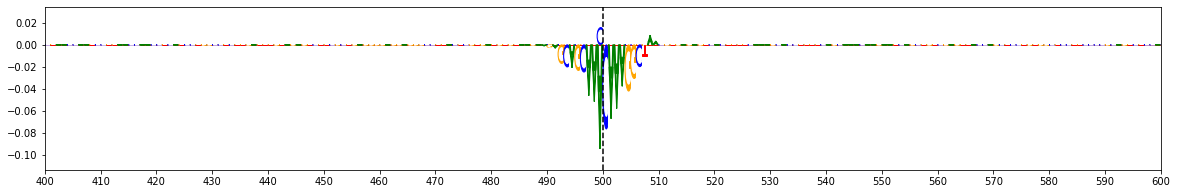



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 128

RSID: rs79436576   ||    chr17 : 4901871 - 4901872   ||    Locus: 55   ||    IDR Peak: False

GWAS: Alzheimers_Lambert_2013   ||    P-Value: 4.7890E-05   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 1.0212   ||   Center / 200bp : 0.2545

Noneffect Motif: TGGCCCCGCCCC


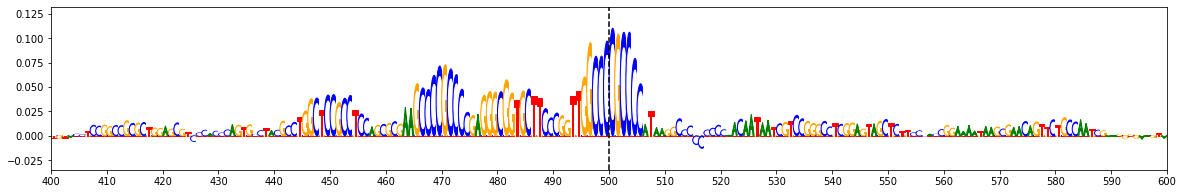

Effect Allele: T   ||   Effect Center: 0.1803   ||   Center / 200bp : 0.0625

Effect Motif: TGGCCTCGCCCC


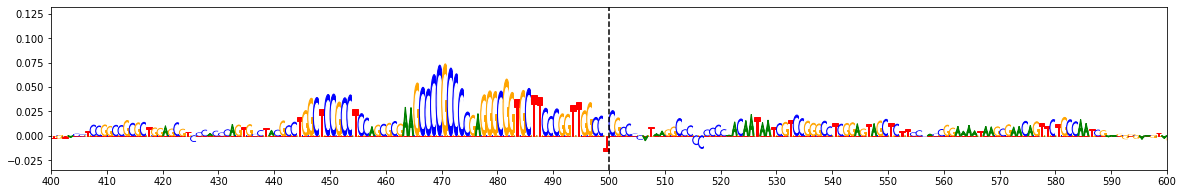

gkmExplain Score: -0.192  ||  ISM Score: -1.3618  ||  deltaSVM Score: -8.0212

gkmExplain P-Value: 0.044117  ||  ISM P-Value: 0.00668  ||  deltaSVM P-Value: 0.009143

Difference Motif: TGGCC(C/T)CGCCCC


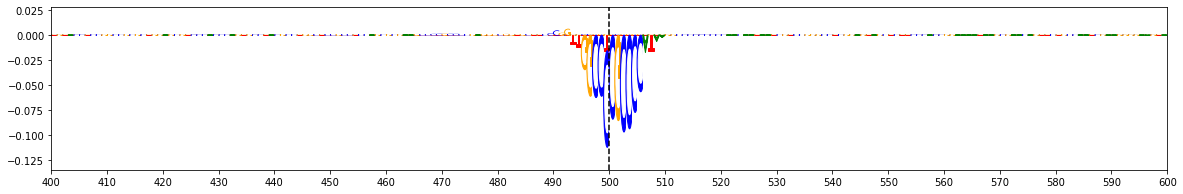



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 196

RSID: rs62054817   ||    chr17 : 45848599 - 45848600   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.1366E-22   ||    Coloc: True   ||    Confidence: 2


Noneffect Allele: A   ||   Noneffect Center: 1.6338   ||   Center / 200bp : 0.6613

Noneffect Motif: CCAGTAGAGGGC


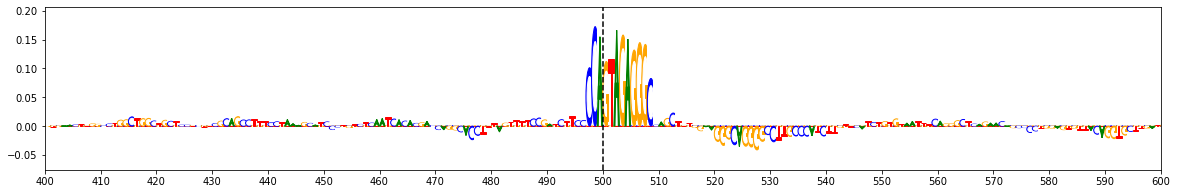

Effect Allele: G   ||   Effect Center: 0.7436   ||   Center / 200bp : 0.4711

Effect Motif: CCGGTAGAGGGC


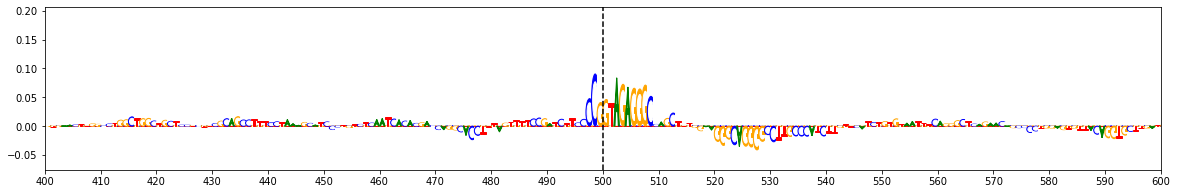

gkmExplain Score: -0.1902  ||  ISM Score: -1.4057  ||  deltaSVM Score: -8.0755

gkmExplain P-Value: 0.045006  ||  ISM P-Value: 0.005836  ||  deltaSVM P-Value: 0.008919

Difference Motif: CC(A/G)GTAGAGGGC


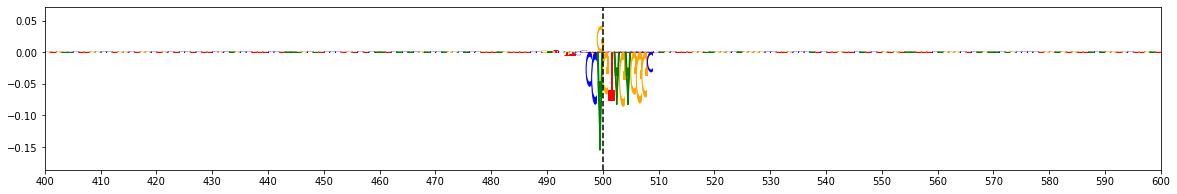



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 173

RSID: rs62057073   ||    chr17 : 45783750 - 45783751   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 2.1576E-22   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: C   ||   Noneffect Center: 0.5994   ||   Center / 200bp : 0.2405

Noneffect Motif: GCTCCTCCTAG


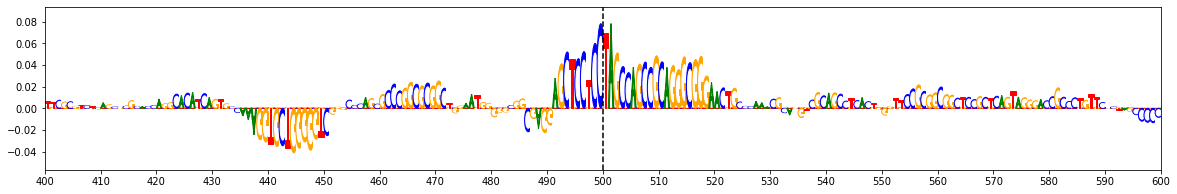

Effect Allele: T   ||   Effect Center: 0.1296   ||   Center / 200bp : 0.0739

Effect Motif: GCTCCTCTTAG


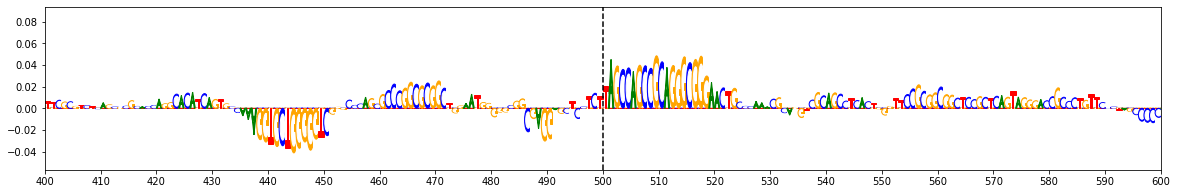

gkmExplain Score: -0.1667  ||  ISM Score: -0.8092  ||  deltaSVM Score: -4.9471

gkmExplain P-Value: 0.059129  ||  ISM P-Value: 0.04715  ||  deltaSVM P-Value: 0.046331

Difference Motif: GCTCCTC(C/T)TAG


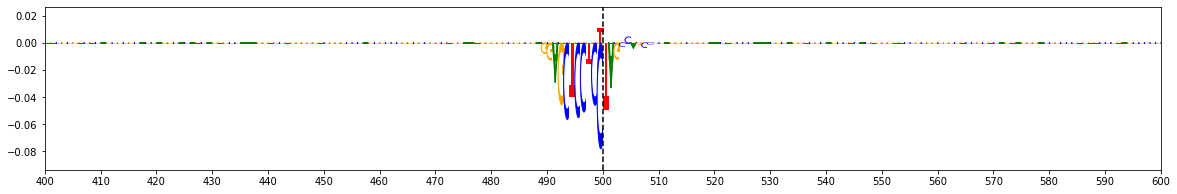



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 423

RSID: rs117310449   ||    chr19 : 44890258 - 44890259   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 7.0428E-94   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: C   ||   Noneffect Center: 0.3483   ||   Center / 200bp : 0.2847

Noneffect Motif: CAGAGTGATGA


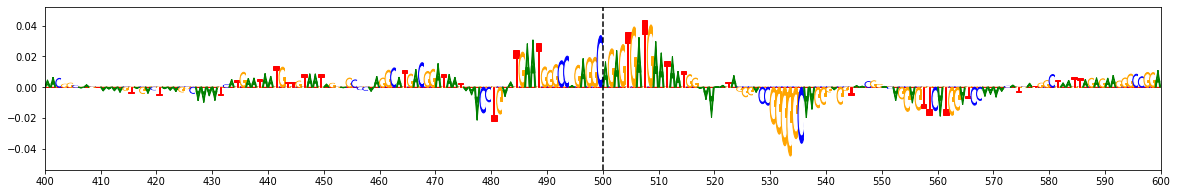

Effect Allele: T   ||   Effect Center: -0.0119   ||   Center / 200bp : 0.1227

Effect Motif: TAGAGTGATGA


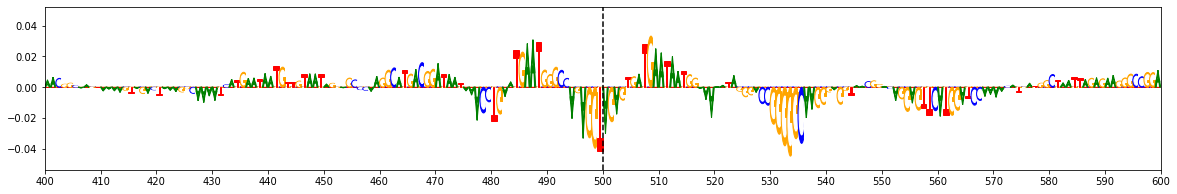

gkmExplain Score: -0.162  ||  ISM Score: -0.9366  ||  deltaSVM Score: -5.3551

gkmExplain P-Value: 0.062674  ||  ISM P-Value: 0.028795  ||  deltaSVM P-Value: 0.03637

Difference Motif: (C/T)AGAGTGATGA


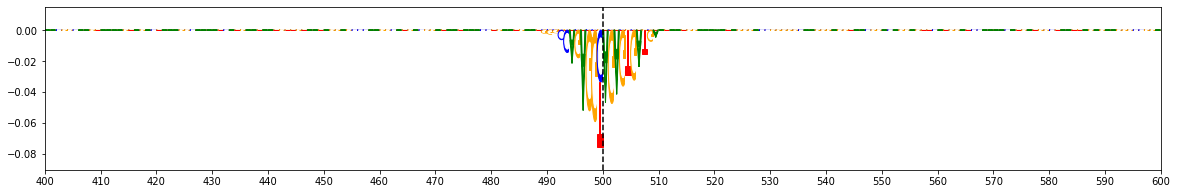



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 56

RSID: rs1237999   ||    chr11 : 86103987 - 86103988   ||    Locus: 16   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 7.1431E-16   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: G   ||   Noneffect Center: 0.5425   ||   Center / 200bp : 0.1885

Noneffect Motif: TGAGTCACCAAC


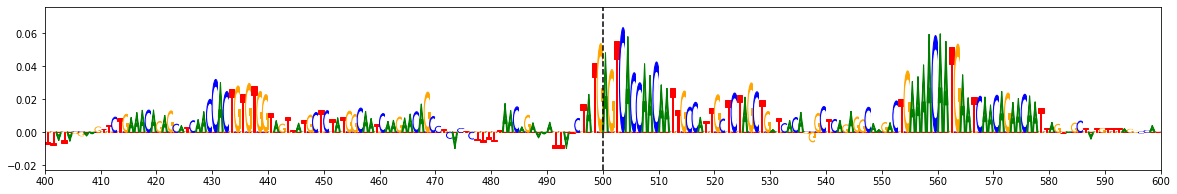

Effect Allele: A   ||   Effect Center: -0.0239   ||   Center / 200bp : 0.0365

Effect Motif: TAAGTCACCAAC


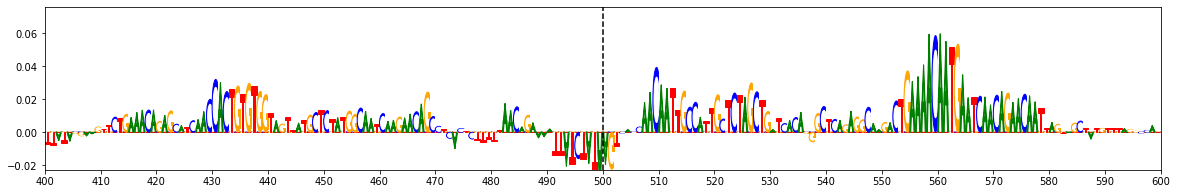

gkmExplain Score: -0.1519  ||  ISM Score: -1.1065  ||  deltaSVM Score: -6.3478

gkmExplain P-Value: 0.071241  ||  ISM P-Value: 0.015519  ||  deltaSVM P-Value: 0.020908

Difference Motif: T(G/A)AGTCACCAAC


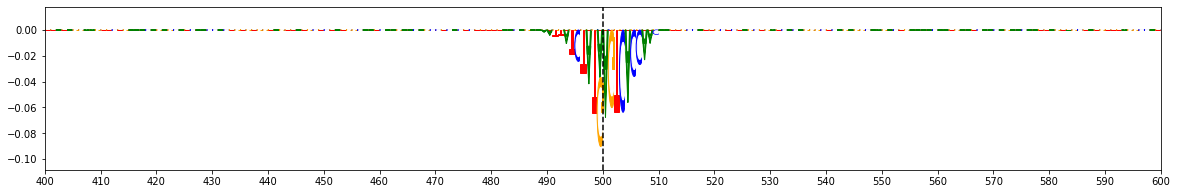



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 528

RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 92   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 2.3493E-03   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: C   ||   Noneffect Center: 1.0317   ||   Center / 200bp : 0.341

Noneffect Motif: GAGGGCGCTGT


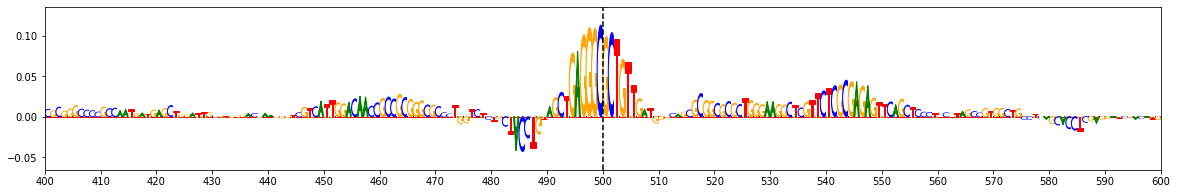

Effect Allele: T   ||   Effect Center: 0.4559   ||   Center / 200bp : 0.1948

Effect Motif: GAGGGTGCTGT


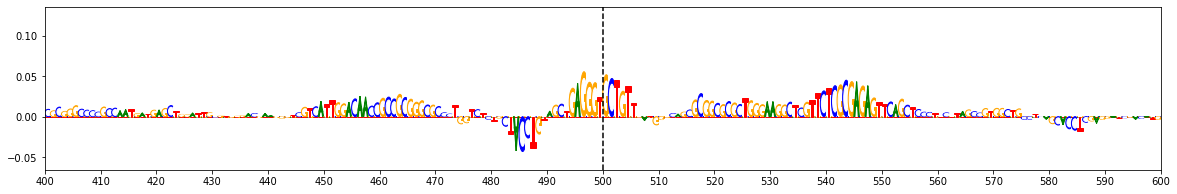

gkmExplain Score: -0.1462  ||  ISM Score: -1.0961  ||  deltaSVM Score: -6.345

gkmExplain P-Value: 0.076852  ||  ISM P-Value: 0.016095  ||  deltaSVM P-Value: 0.02094

Difference Motif: GAGGG(C/T)GCTGT


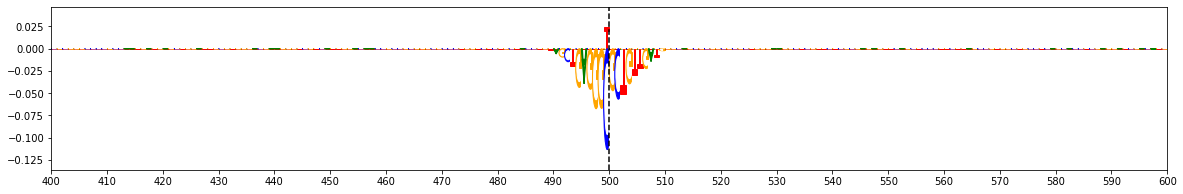



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 467

RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 1.2157E-04   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: G   ||   Noneffect Center: 0.2878   ||   Center / 200bp : 0.3928

Noneffect Motif: GCCTCCACTGT


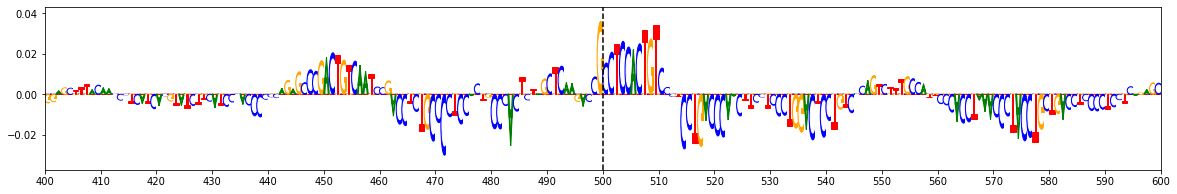

Effect Allele: C   ||   Effect Center: 0.0188   ||   Center / 200bp : 0.2712

Effect Motif: CCCTCCACTGT


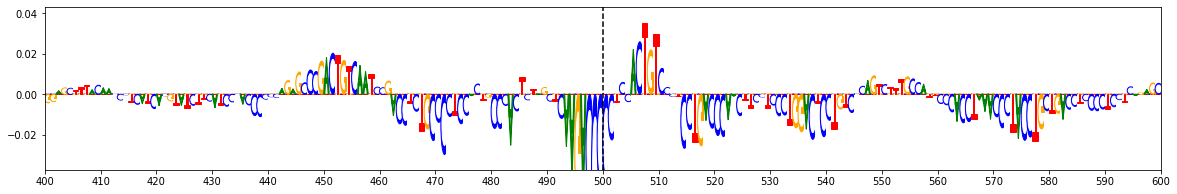

gkmExplain Score: -0.1216  ||  ISM Score: -1.0274  ||  deltaSVM Score: -5.9455

gkmExplain P-Value: 0.109222  ||  ISM P-Value: 0.020569  ||  deltaSVM P-Value: 0.026011

Difference Motif: (G/C)CCTCCACTGT


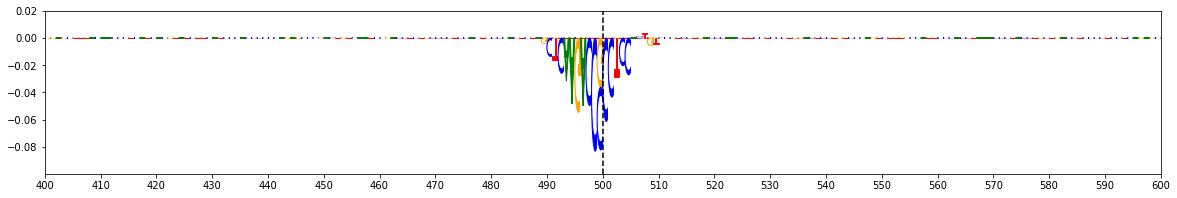



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 381

RSID: rs72914885   ||    chr17 : 78426790 - 78426791   ||    Locus: 62   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 4.4672E-02   ||    Coloc: False   ||    Confidence: 1


Noneffect Allele: A   ||   Noneffect Center: 0.3236   ||   Center / 200bp : 0.118

Noneffect Motif: ACTGCCAG


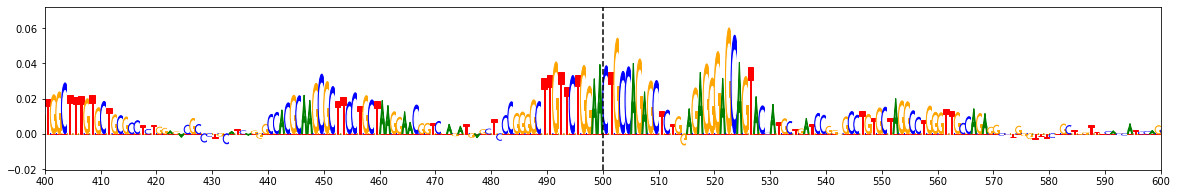

Effect Allele: C   ||   Effect Center: -0.0137   ||   Center / 200bp : 0.0277

Effect Motif: CCTGCCAG


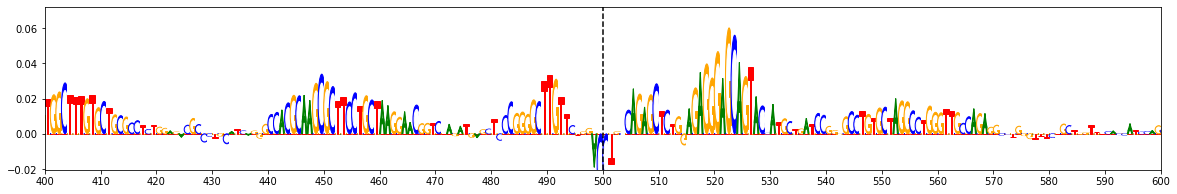

gkmExplain Score: -0.0902  ||  ISM Score: -0.8841  ||  deltaSVM Score: -5.2518

gkmExplain P-Value: 0.182422  ||  ISM P-Value: 0.035185  ||  deltaSVM P-Value: 0.038639

Difference Motif: (A/C)CTGCCAG


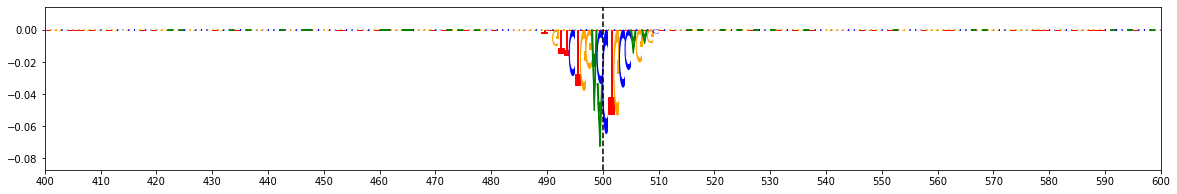



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 405

RSID: rs8103622   ||    chr19 : 18462023 - 18462024   ||    Locus: 69   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 1.2790E-05   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: C   ||   Noneffect Center: 2.4716   ||   Center / 200bp : 0.6843

Noneffect Motif: AGAGCGCCACCTGCTG


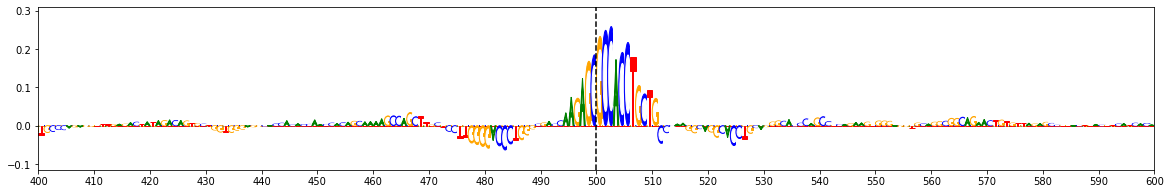

Effect Allele: T   ||   Effect Center: 1.8806   ||   Center / 200bp : 0.6233

Effect Motif: AGAGTGCCACCTGCTG


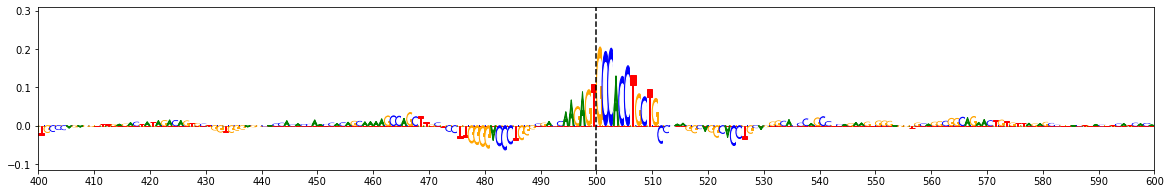

gkmExplain Score: -0.061  ||  ISM Score: -0.975  ||  deltaSVM Score: -5.5563

gkmExplain P-Value: 0.315533  ||  ISM P-Value: 0.02494  ||  deltaSVM P-Value: 0.032379

Difference Motif: AGAG(C/T)GCCACCTGCTG


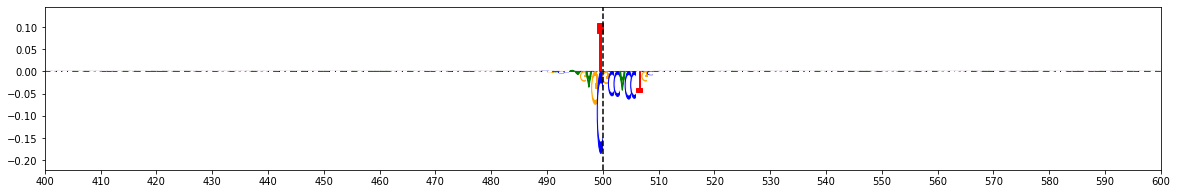



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 636

RSID: rs26523   ||    chr5 : 103120549 - 103120550   ||    Locus: 104   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 1.0848E-03   ||    Coloc: False   ||    Confidence: 0


Noneffect Allele: C   ||   Noneffect Center: 0.0523   ||   Center / 200bp : 0.0273

Noneffect Motif: GAGGCGGCTG


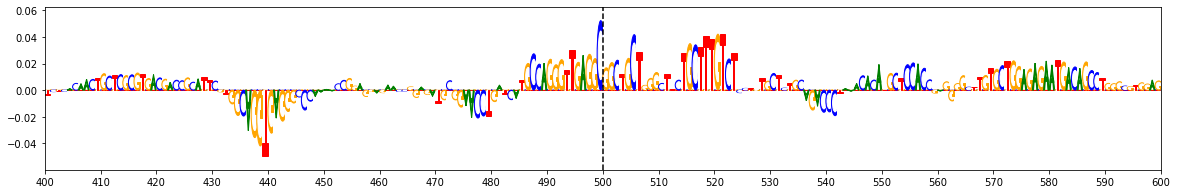

Effect Allele: T   ||   Effect Center: -0.0207   ||   Center / 200bp : 0.0

Effect Motif: GAGGTGGCTG


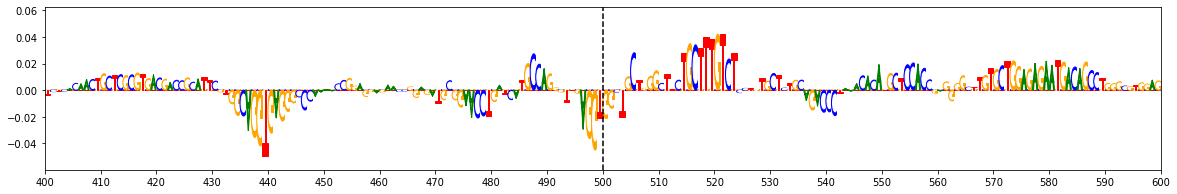

gkmExplain Score: -0.0273  ||  ISM Score: -0.894  ||  deltaSVM Score: -5.1559

gkmExplain P-Value: 0.619437  ||  ISM P-Value: 0.033868  ||  deltaSVM P-Value: 0.040889

Difference Motif: GAGG(C/T)GGCTG


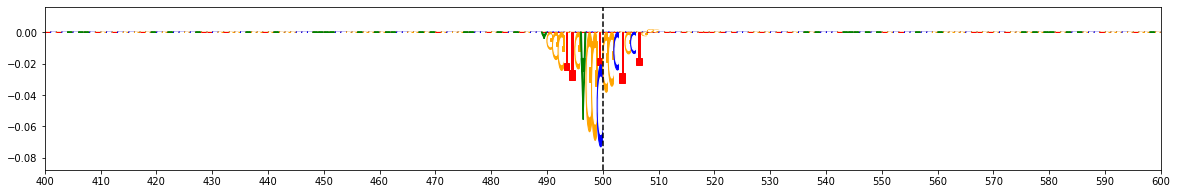



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 283

RSID: rs17572495   ||    chr17 : 45977229 - 45977230   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 2.2862E-22   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.0467   ||   Center / 200bp : 0.0196

Noneffect Motif: GGCTGCCAGG


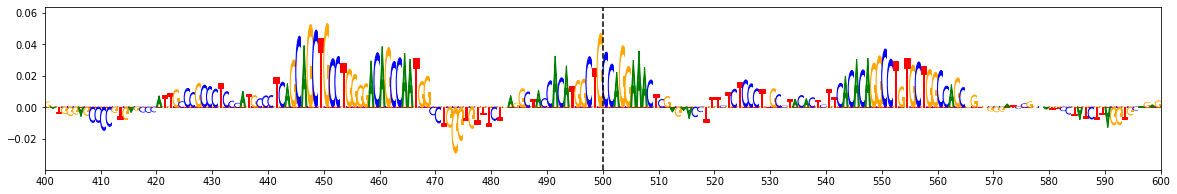

Effect Allele: T   ||   Effect Center: -0.0207   ||   Center / 200bp : 0.0

Effect Motif: GGCTTCCAGG


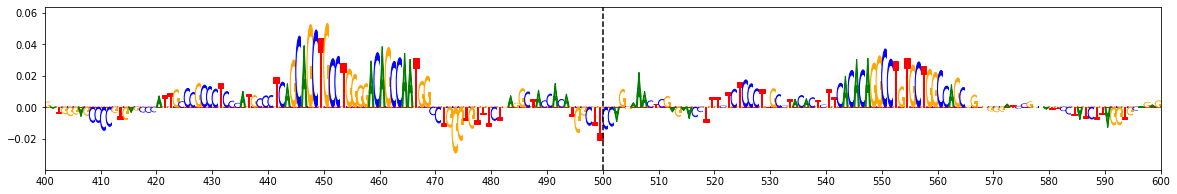

gkmExplain Score: -0.0196  ||  ISM Score: -0.8331  ||  deltaSVM Score: -4.8312

gkmExplain P-Value: 0.717439  ||  ISM P-Value: 0.042911  ||  deltaSVM P-Value: 0.049707

Difference Motif: GGCT(G/T)CCAGG


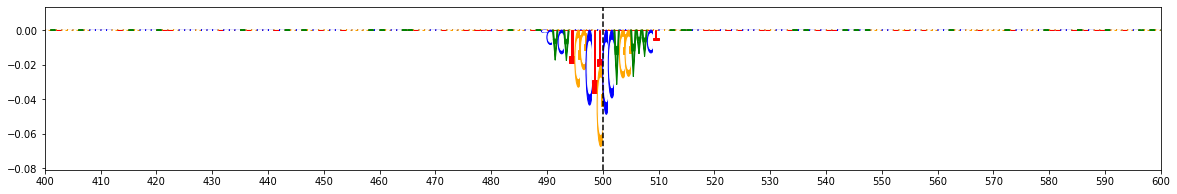



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 370

RSID: rs7218004   ||    chr17 : 75032747 - 75032748   ||    Locus: 61   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 8.5410E-06   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: G   ||   Noneffect Center: 0.0309   ||   Center / 200bp : 0.0147

Noneffect Motif: CGGGCGGGTT


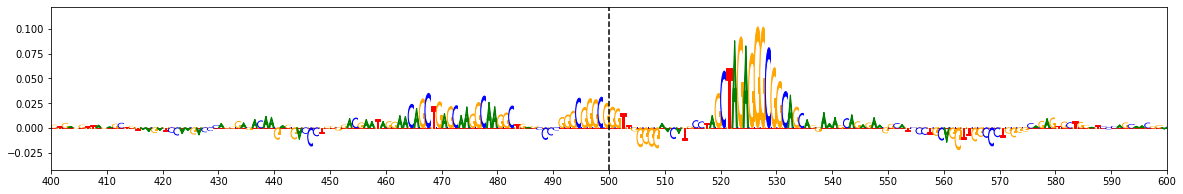

Effect Allele: A   ||   Effect Center: -0.039   ||   Center / 200bp : 0.0

Effect Motif: CGGGCAGGTT


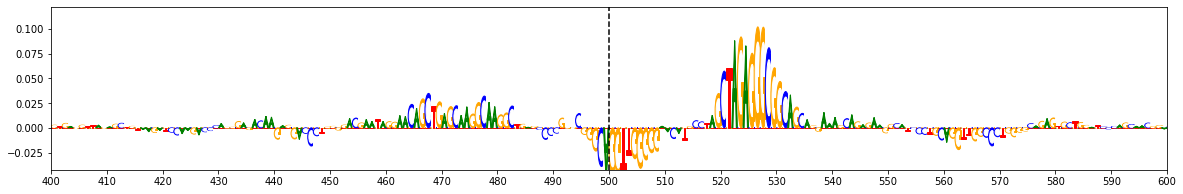

gkmExplain Score: -0.0147  ||  ISM Score: -0.9746  ||  deltaSVM Score: -5.5934

gkmExplain P-Value: 0.783996  ||  ISM P-Value: 0.024977  ||  deltaSVM P-Value: 0.031699

Difference Motif: CGGGC(G/A)GGTT


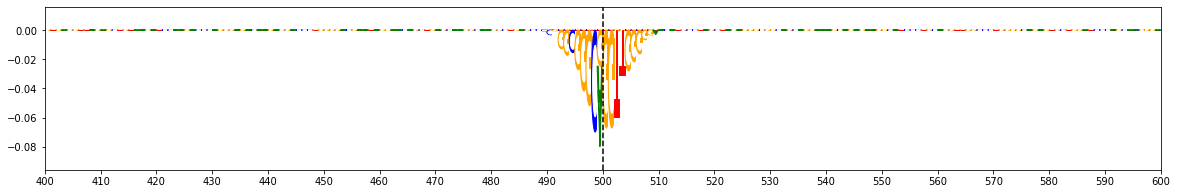



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 228

RSID: rs111972148   ||    chr17 : 45895754 - 45895755   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 3.9382E-22   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: C   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CCCACCCCCC


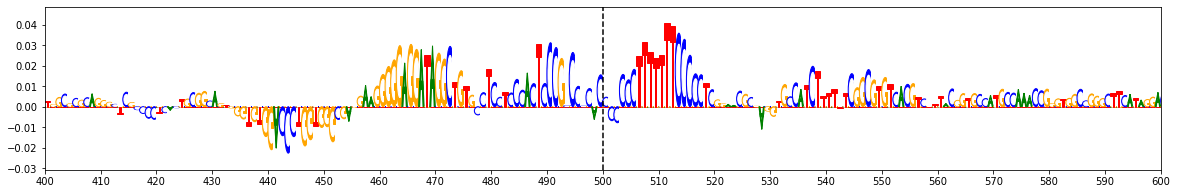

Effect Allele: G   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CCCAGCCCCC


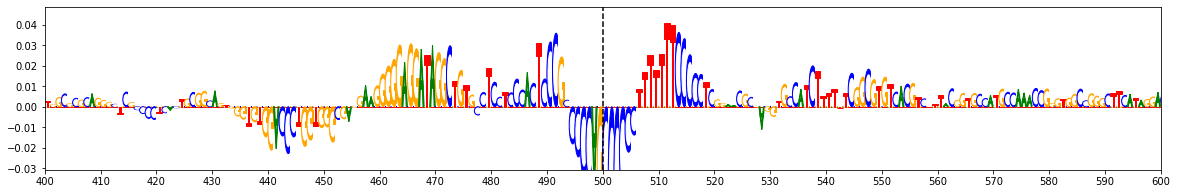

gkmExplain Score: 0.0  ||  ISM Score: -0.9185  ||  deltaSVM Score: -5.5787

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.030835  ||  deltaSVM P-Value: 0.031967

Difference Motif: CCCA(C/G)CCCCC


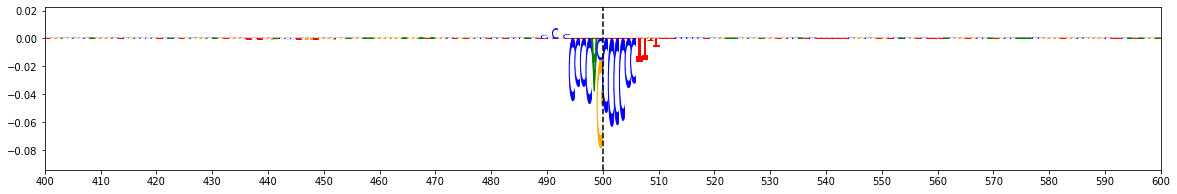



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 216

RSID: rs56365901   ||    chr17 : 45882956 - 45882957   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 4.4213E-22   ||    Coloc: True   ||    Confidence: 0


Noneffect Allele: A   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: TGGGAGTCTG


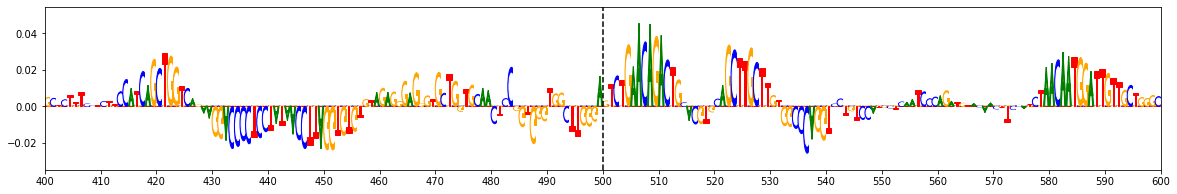

Effect Allele: G   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: TGGGGGTCTG


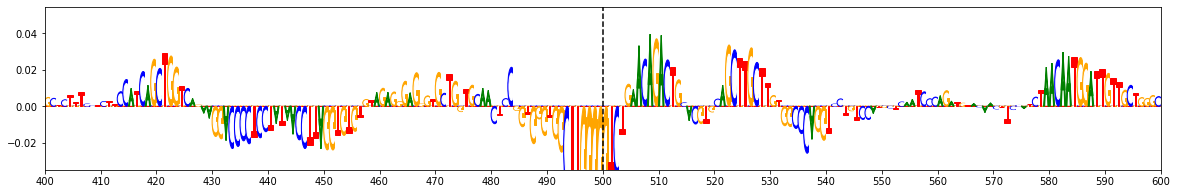

gkmExplain Score: 0.0  ||  ISM Score: -1.1701  ||  deltaSVM Score: -6.9789

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.01246  ||  deltaSVM P-Value: 0.01508

Difference Motif: TGGG(A/G)GTCTG


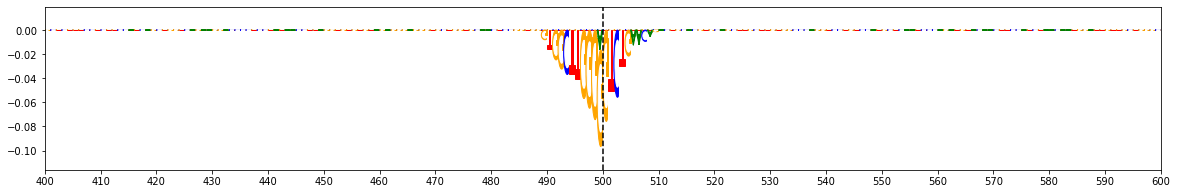



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [18]:
neg_diff_motifs = []

for idx in neg_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], 
          ':', neg_snps.at[idx, 'start'],
          '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', neg_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', neg_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(neg_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', neg_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', neg_snps.at[idx, 'confidence'])
    print()
    print()
    
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', neg_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', neg_snps.at[idx, 'major'],
              '  ||   Major Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if neg_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', neg_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', neg_snps.at[idx, 'motif_other'])
    else:
        print('Minor Allele:', neg_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', neg_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(neg_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(neg_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(neg_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(neg_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(neg_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(neg_snps.at[idx, 'delta_pval'], 6))
    print()
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'noneffect']
                      + '/' + neg_snps.at[idx, 'effect']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    else:
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'major']
                      + '/' + neg_snps.at[idx, 'minor']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    print('Difference Motif:', diff_motif)
    neg_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
neg_snps['diff_motif'] = neg_diff_motifs

# Visualize Top Positive Scoring SNPs <a name='pos_snps' />


Index: 204

RSID: rs62054825   ||    chr17 : 45852666 - 45852667   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.2470E-22   ||    Coloc: True   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 0.7627   ||   Center / 200bp : 0.5799

Effect Motif: CCGGAAGTGGAGT


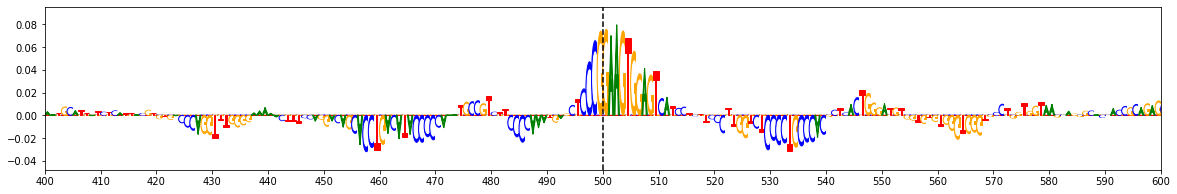

Noneffect Allele: A   ||   Noneffect Center: 0.0979   ||   Center / 200bp : 0.2069

Noneffect Motif: CCAGAAGTGGAGT


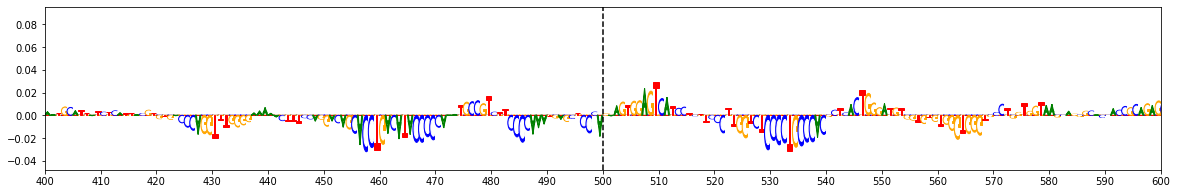

gkmExplain Score: 0.373  ||  ISM Score: 1.1377  ||  deltaSVM Score: 6.4779

gkmExplain P-Value: 0.010267  ||  ISM P-Value: 0.013924  ||  deltaSVM P-Value: 0.019516

Difference Motif: CC(G/A)GAAGTGGAGT


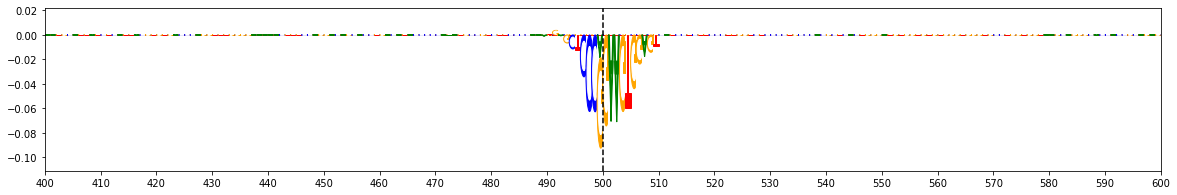



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 471

RSID: rs7585473   ||    chr2 : 95074354 - 95074355   ||    Locus: 85   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 3.6732E-02   ||    Coloc: False   ||    Confidence: 2


Effect Allele: T   ||   Effect Center: 0.4849   ||   Center / 200bp : 0.2551

Effect Motif: CCATTGT


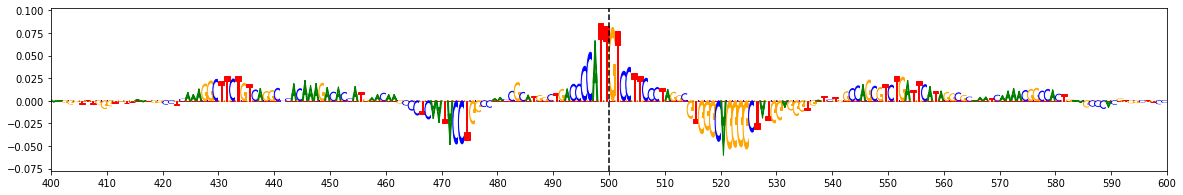

Noneffect Allele: G   ||   Noneffect Center: -0.158   ||   Center / 200bp : 0.0

Noneffect Motif: CCATGGT


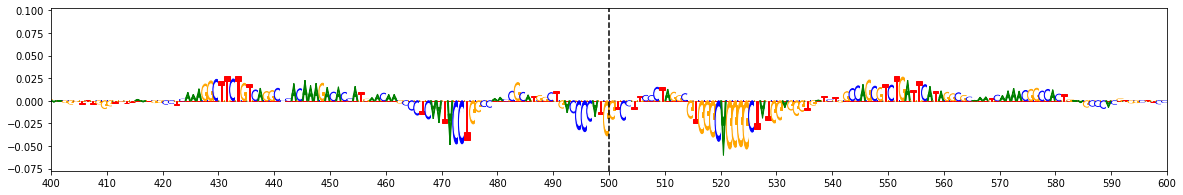

gkmExplain Score: 0.2551  ||  ISM Score: 1.4868  ||  deltaSVM Score: 8.5173

gkmExplain P-Value: 0.023969  ||  ISM P-Value: 0.00458  ||  deltaSVM P-Value: 0.007319

Difference Motif: CCAT(T/G)GT


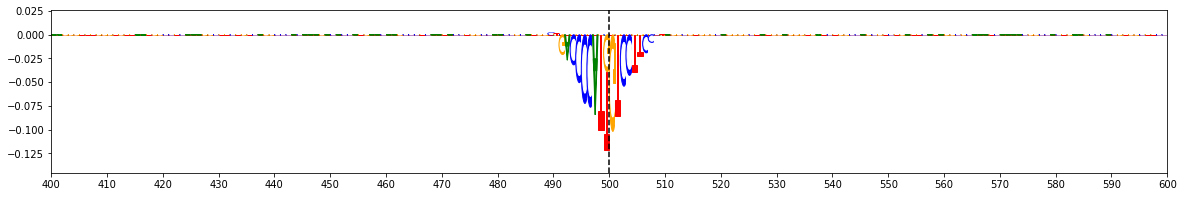



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 360

RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 9.4929E-14   ||    Coloc: True   ||    Confidence: 2


Effect Allele: C   ||   Effect Center: 1.1351   ||   Center / 200bp : 0.4071

Effect Motif: GCGCCACCTACAG


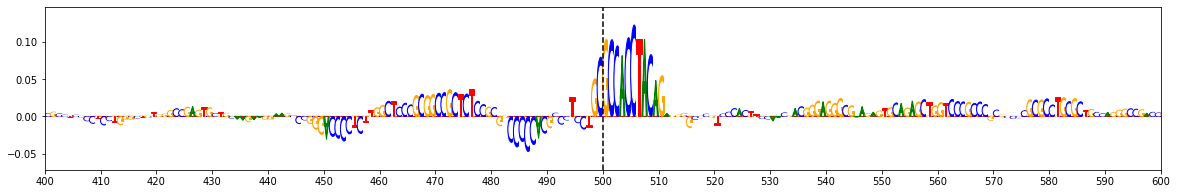

Noneffect Allele: A   ||   Noneffect Center: 0.398   ||   Center / 200bp : 0.211

Noneffect Motif: GAGCCACCTACAG


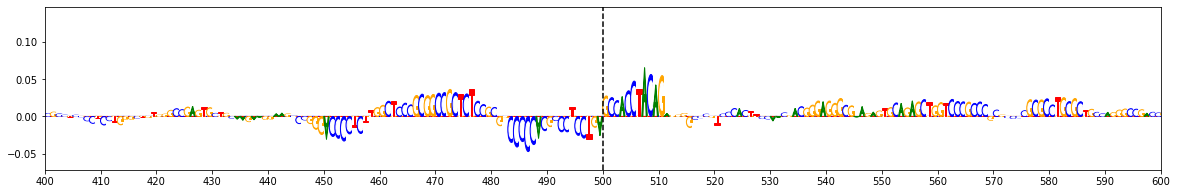

gkmExplain Score: 0.1961  ||  ISM Score: 1.3111  ||  deltaSVM Score: 7.5776

gkmExplain P-Value: 0.042197  ||  ISM P-Value: 0.007834  ||  deltaSVM P-Value: 0.011248

Difference Motif: G(C/A)GCCACCTACAG


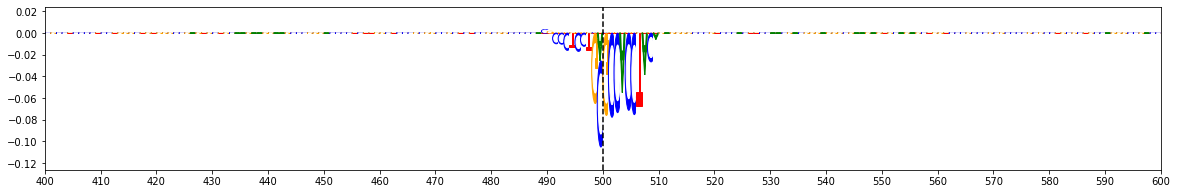



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 234

RSID: rs80346216   ||    chr17 : 45897109 - 45897110   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 3.9387E-22   ||    Coloc: True   ||    Confidence: 1


Effect Allele: T   ||   Effect Center: 0.9844   ||   Center / 200bp : 0.3719

Effect Motif: GCCGCTAGGGG


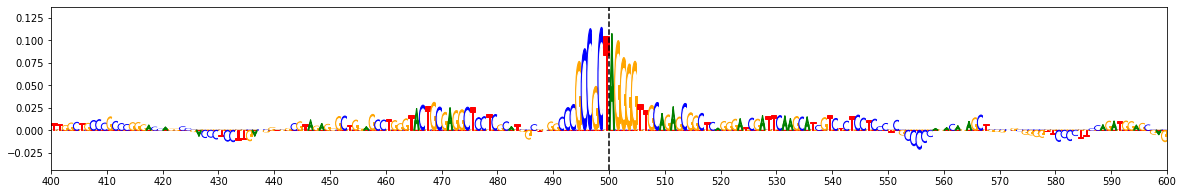

Noneffect Allele: G   ||   Noneffect Center: 0.4065   ||   Center / 200bp : 0.2056

Noneffect Motif: GCCGCGAGGGG


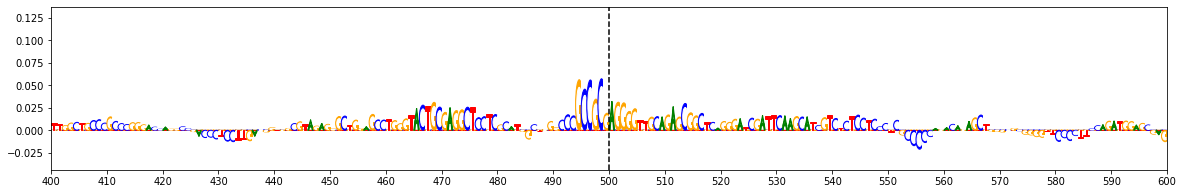

gkmExplain Score: 0.1662  ||  ISM Score: 1.0452  ||  deltaSVM Score: 5.9712

gkmExplain P-Value: 0.059441  ||  ISM P-Value: 0.019288  ||  deltaSVM P-Value: 0.025645

Difference Motif: GCCGC(T/G)AGGGG


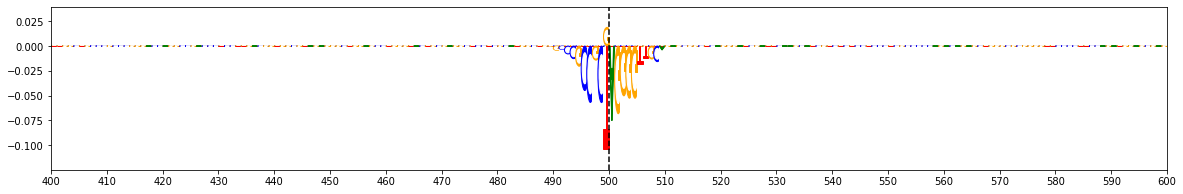



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 500

RSID: rs3845674   ||    chr2 : 127117812 - 127117813   ||    Locus: 77   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 3.3725E-12   ||    Coloc: False   ||    Confidence: 1


Effect Allele: T   ||   Effect Center: 0.2107   ||   Center / 200bp : 0.1454

Effect Motif: CGCGCAGTTG


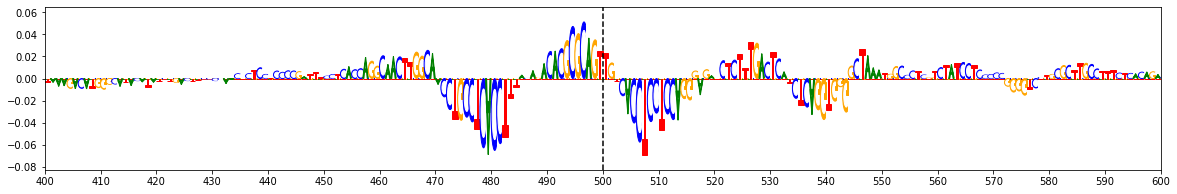

Noneffect Allele: G   ||   Noneffect Center: -0.0492   ||   Center / 200bp : 0.0118

Noneffect Motif: CGCGCAGGTG


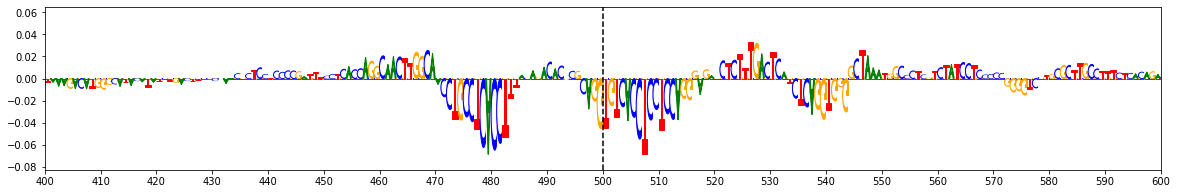

gkmExplain Score: 0.1337  ||  ISM Score: 0.858  ||  deltaSVM Score: 4.9263

gkmExplain P-Value: 0.091418  ||  ISM P-Value: 0.038926  ||  deltaSVM P-Value: 0.046917

Difference Motif: CGCGCAG(T/G)TG


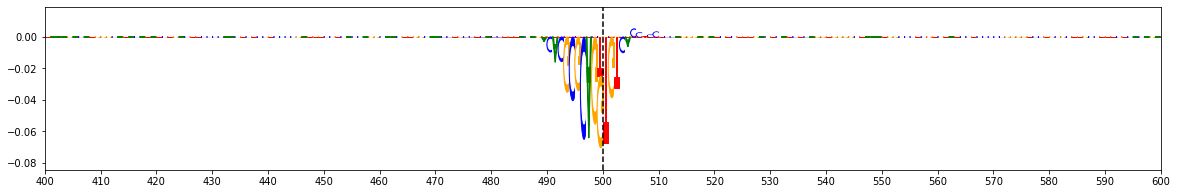



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 377

RSID: rs3744216   ||    chr17 : 78414789 - 78414790   ||    Locus: 62   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 5.9224E-02   ||    Coloc: False   ||    Confidence: 1


Effect Allele: G   ||   Effect Center: 0.222   ||   Center / 200bp : 0.1259

Effect Motif: AGGCCGCCTT


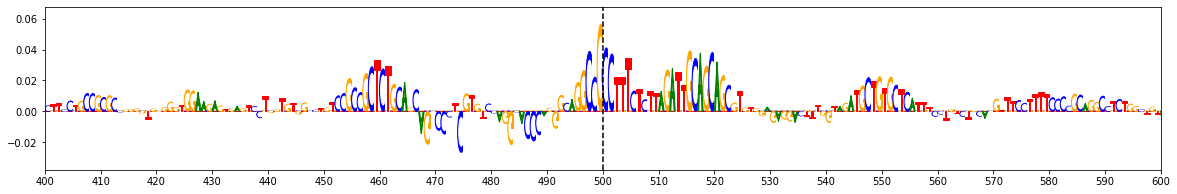

Noneffect Allele: A   ||   Noneffect Center: -0.2443   ||   Center / 200bp : 0.0

Noneffect Motif: AGGCCACCTT


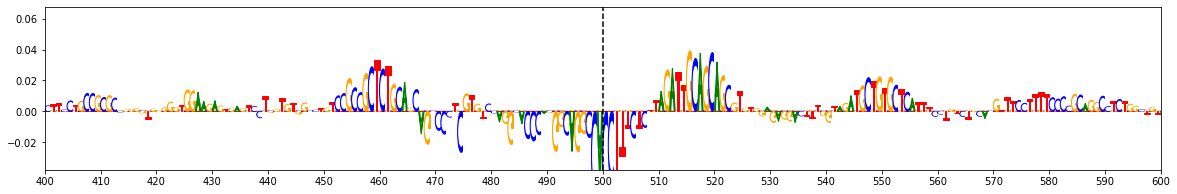

gkmExplain Score: 0.1259  ||  ISM Score: 1.3513  ||  deltaSVM Score: 7.7513

gkmExplain P-Value: 0.102391  ||  ISM P-Value: 0.006902  ||  deltaSVM P-Value: 0.010361

Difference Motif: AGGCC(G/A)CCTT


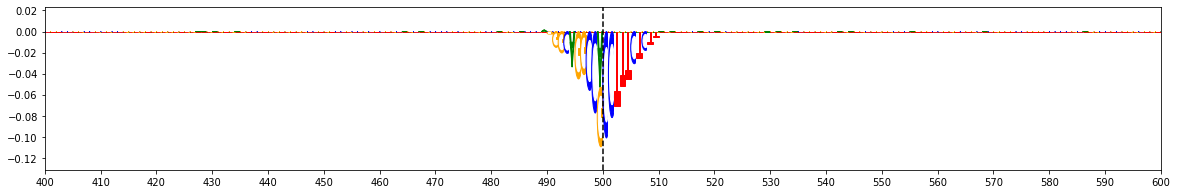



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 175

RSID: rs3885075   ||    chr17 : 45825432 - 45825433   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.3382E-22   ||    Coloc: True   ||    Confidence: 1


Effect Allele: G   ||   Effect Center: 0.1342   ||   Center / 200bp : 0.0878

Effect Motif: CCACCCGCCC


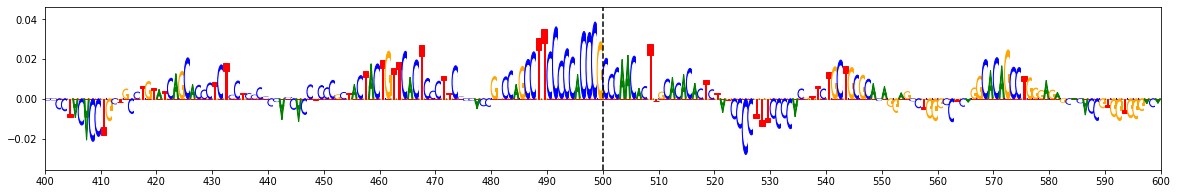

Noneffect Allele: A   ||   Noneffect Center: -0.0936   ||   Center / 200bp : 0.0

Noneffect Motif: CCACCCACCC


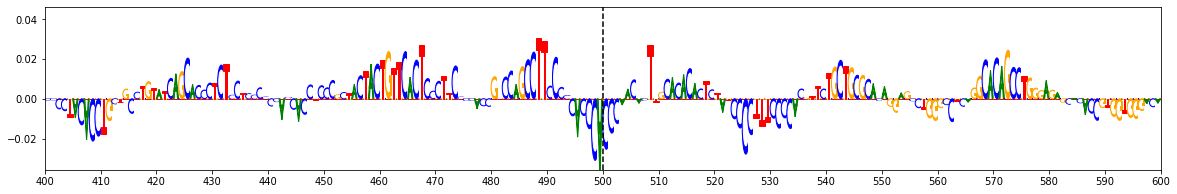

gkmExplain Score: 0.0878  ||  ISM Score: 0.8574  ||  deltaSVM Score: 4.9381

gkmExplain P-Value: 0.190664  ||  ISM P-Value: 0.039016  ||  deltaSVM P-Value: 0.046584

Difference Motif: CCACCC(G/A)CCC


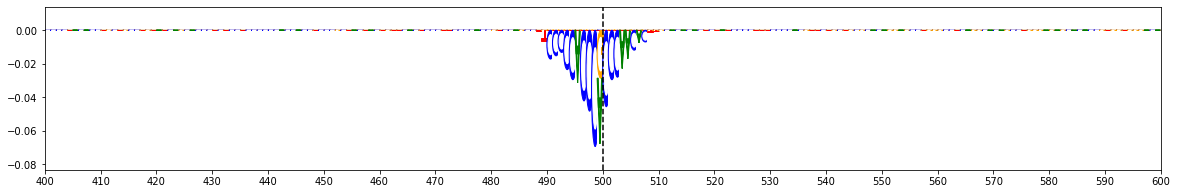



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 294

RSID: 17_46003042   ||    chr17 : 46003041 - 46003042   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 2.1779E-22   ||    Coloc: True   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.0264   ||   Center / 200bp : 0.0358

Effect Motif: CCTCGCAAAT


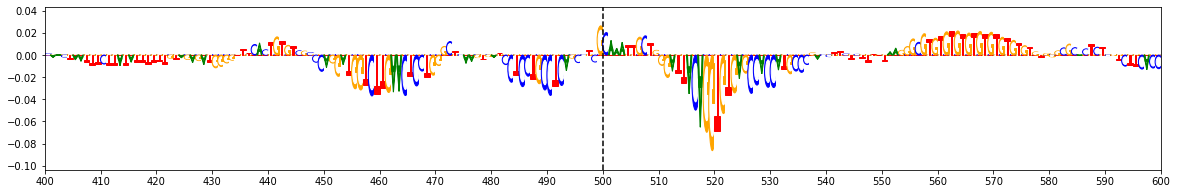

Noneffect Allele: C   ||   Noneffect Center: -0.0573   ||   Center / 200bp : 0.0

Noneffect Motif: CCTCCCAAAT


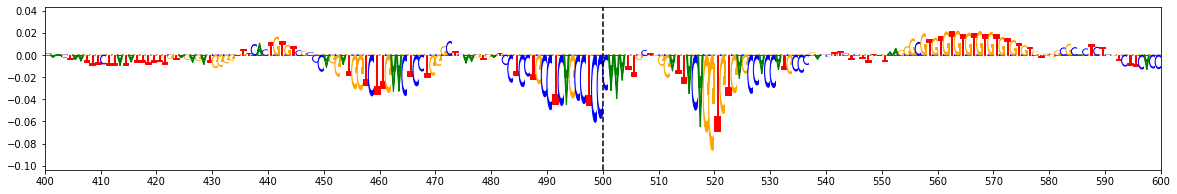

gkmExplain Score: 0.0358  ||  ISM Score: 1.1338  ||  deltaSVM Score: 6.5427

gkmExplain P-Value: 0.523286  ||  ISM P-Value: 0.01411  ||  deltaSVM P-Value: 0.018863

Difference Motif: CCTC(G/C)CAAAT


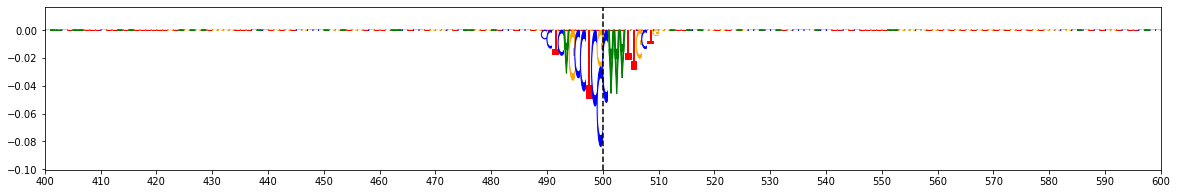



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 534

RSID: rs149776414   ||    chr3 : 52307781 - 52307782   ||    Locus: 93   ||    IDR Peak: False

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 1.0025E-03   ||    Coloc: False   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.0412   ||   Center / 200bp : 0.027

Effect Motif: GCCCGCCAGG


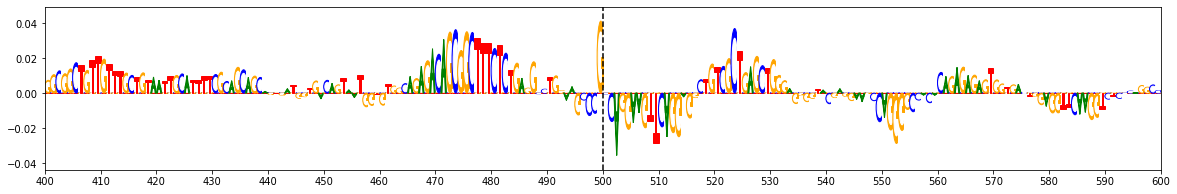

Noneffect Allele: A   ||   Noneffect Center: -0.0448   ||   Center / 200bp : 0.0

Noneffect Motif: GCCCACCAGG


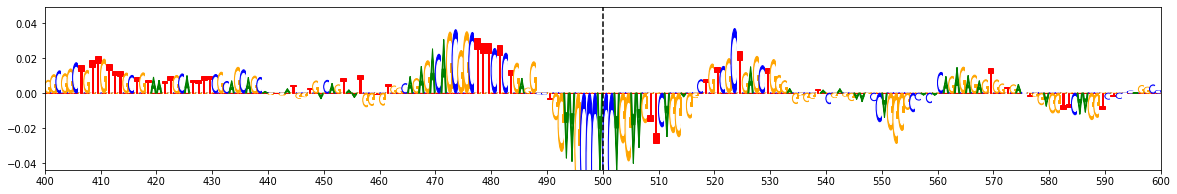

gkmExplain Score: 0.027  ||  ISM Score: 1.1013  ||  deltaSVM Score: 6.375

gkmExplain P-Value: 0.623262  ||  ISM P-Value: 0.0158  ||  deltaSVM P-Value: 0.020608

Difference Motif: GCCC(G/A)CCAGG


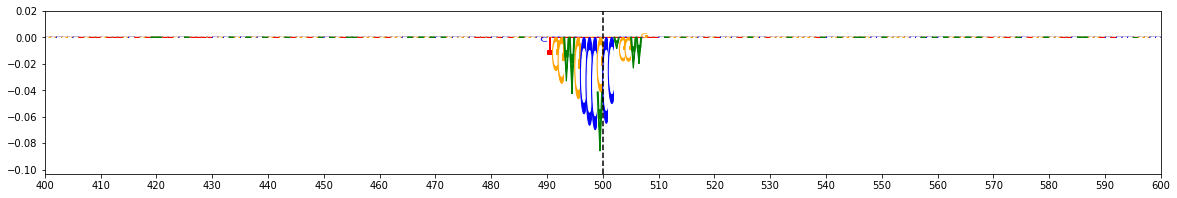



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 668

RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 125   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 5.0811E-02   ||    Coloc: False   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.04   ||   Center / 200bp : 0.023

Effect Motif: CCCCTGCCGC


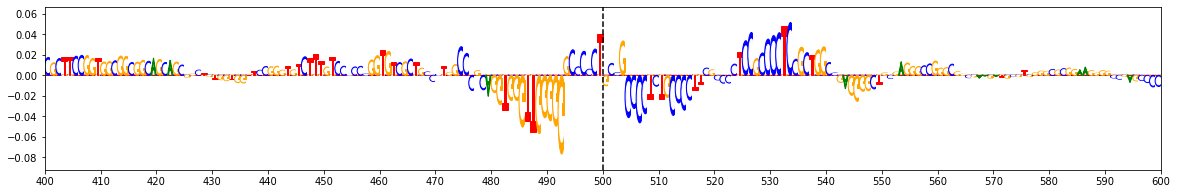

Noneffect Allele: C   ||   Noneffect Center: -0.0533   ||   Center / 200bp : 0.0

Noneffect Motif: CCCCCGCCGC


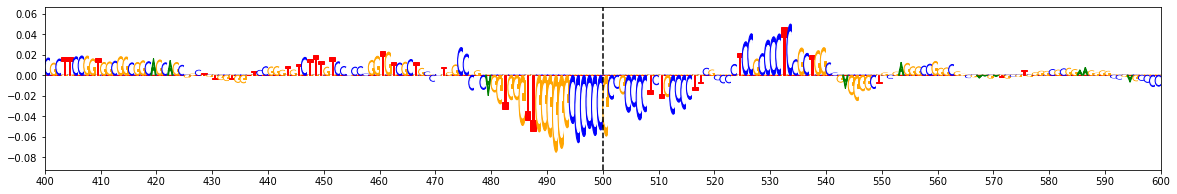

gkmExplain Score: 0.023  ||  ISM Score: 1.0939  ||  deltaSVM Score: 7.2703

gkmExplain P-Value: 0.67321  ||  ISM P-Value: 0.016218  ||  deltaSVM P-Value: 0.013049

Difference Motif: CCCC(T/C)GCCGC


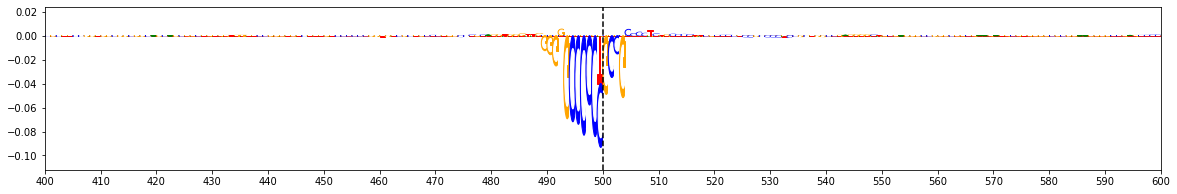



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 259

RSID: rs62061732   ||    chr17 : 45940574 - 45940575   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 3.0356E-22   ||    Coloc: True   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CCAGTTAAGG


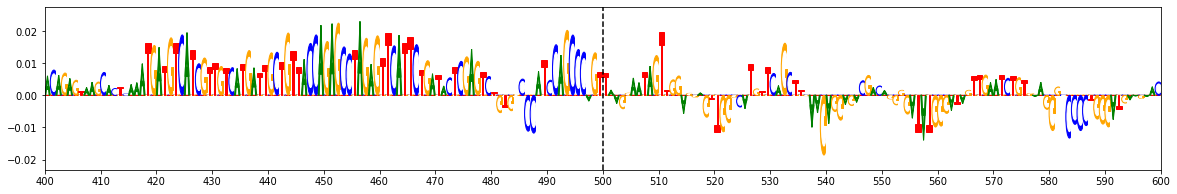

Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CCAGGTAAGG


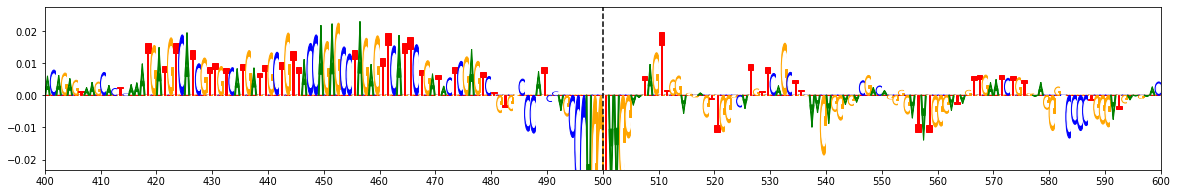

gkmExplain Score: 0.0  ||  ISM Score: 0.9583  ||  deltaSVM Score: 5.5213

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.02654  ||  deltaSVM P-Value: 0.033036

Difference Motif: CCAG(T/G)TAAGG


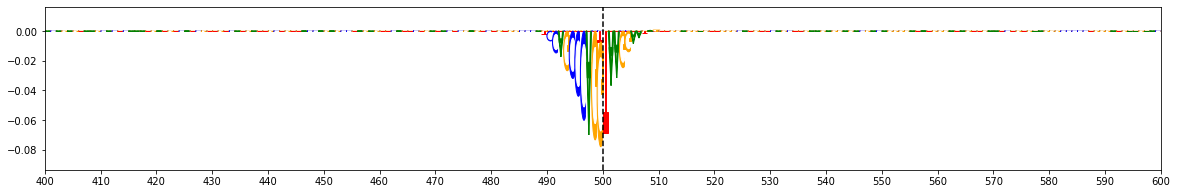



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 476

RSID: rs2248415   ||    chr2 : 95297493 - 95297494   ||    Locus: 85   ||    IDR Peak: True

GWAS: Nalls_23andMe   ||    P-Value: 7.8283E-03   ||    Coloc: False   ||    Confidence: 0


Effect Allele: G   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGGTGGGGGG


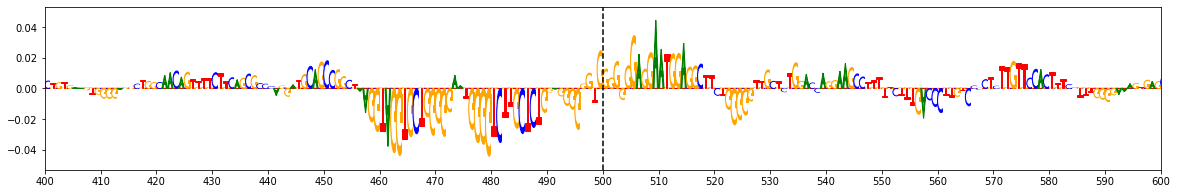

Noneffect Allele: C   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTCGGGGG


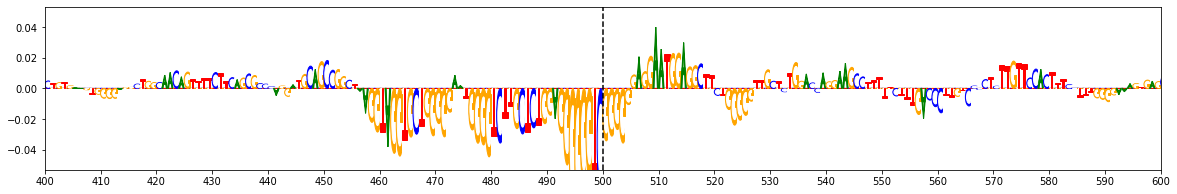

gkmExplain Score: 0.0  ||  ISM Score: 1.1628  ||  deltaSVM Score: 6.746

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.012771  ||  deltaSVM P-Value: 0.016976

Difference Motif: GGGT(G/C)GGGGG


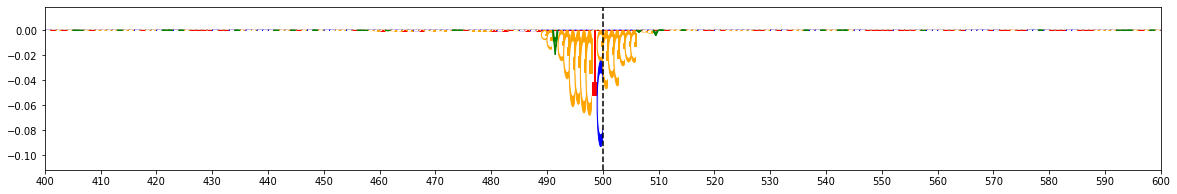



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 437

RSID: rs12691088   ||    chr19 : 44915228 - 44915229   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 2.6900E-238   ||    Coloc: True   ||    Confidence: 0


Effect Allele: A   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: GGGTAGGGGG


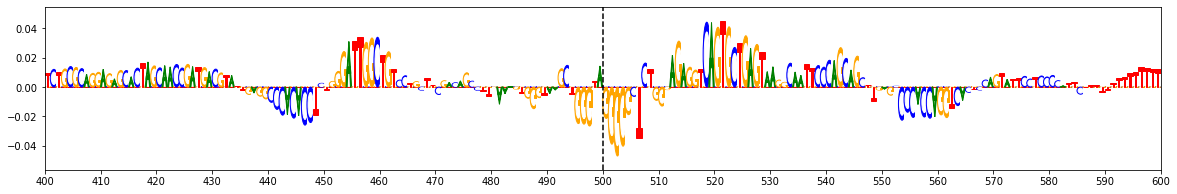

Noneffect Allele: G   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: GGGTGGGGGG


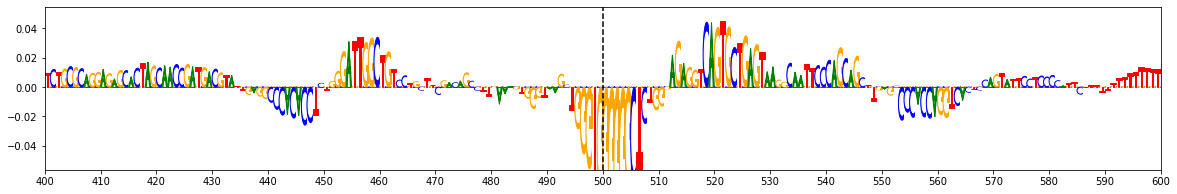

gkmExplain Score: 0.0  ||  ISM Score: 1.1474  ||  deltaSVM Score: 6.6068

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.013466  ||  deltaSVM P-Value: 0.018242

Difference Motif: GGGT(A/G)GGGGG


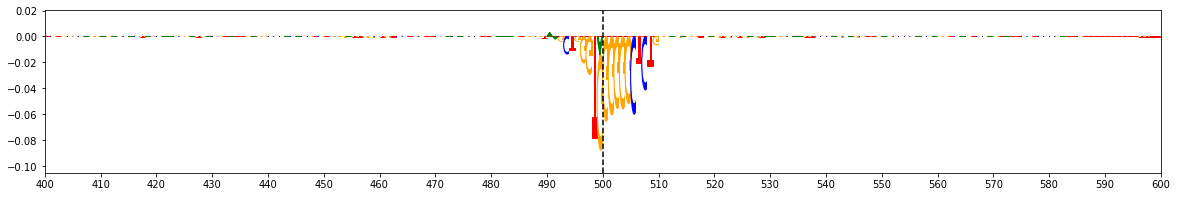



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 197

RSID: rs62054818   ||    chr17 : 45848689 - 45848690   ||    Locus: 54   ||    IDR Peak: True

GWAS: 23andme_PD_hg38   ||    P-Value: 1.8453E-22   ||    Coloc: True   ||    Confidence: 0


Effect Allele: C   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: TTACCGGTGC


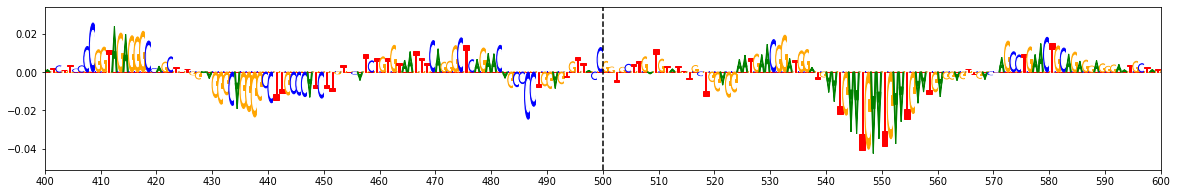

Noneffect Allele: A   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: TTACAGGTGC


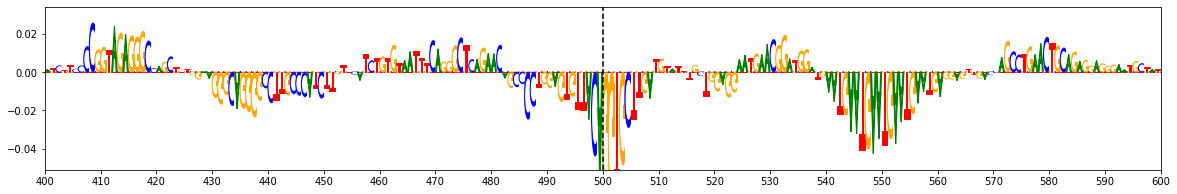

gkmExplain Score: 0.0  ||  ISM Score: 1.0119  ||  deltaSVM Score: 5.7985

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.021766  ||  deltaSVM P-Value: 0.028228

Difference Motif: TTAC(C/A)GGTGC


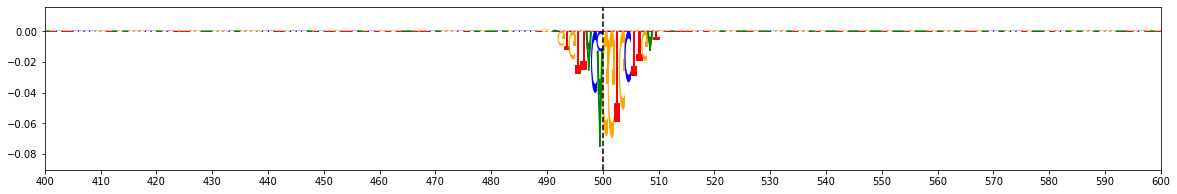



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 316

RSID: rs55714296   ||    chr17 : 46059822 - 46059823   ||    Locus: 54   ||    IDR Peak: False

GWAS: 23andme_PD_hg38   ||    P-Value: 2.5105E-22   ||    Coloc: True   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: ATTCTCCTGC


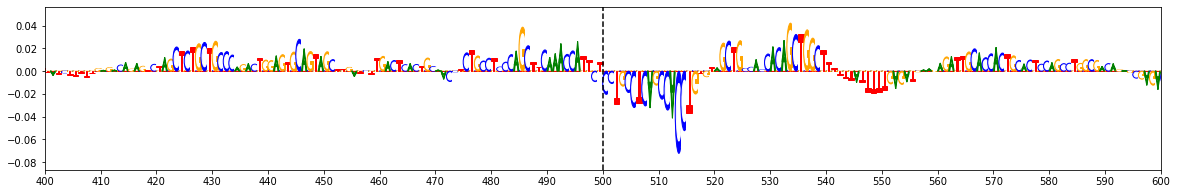

Noneffect Allele: A   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: ATTCACCTGC


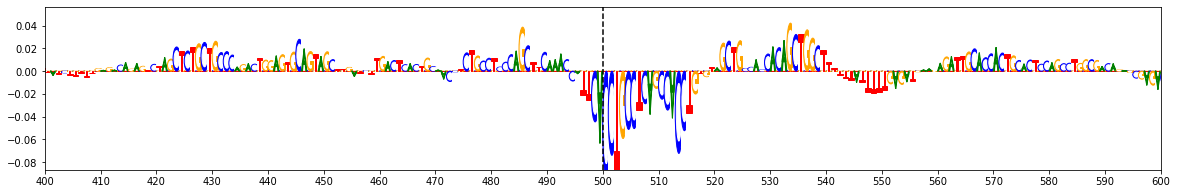

gkmExplain Score: 0.0  ||  ISM Score: 0.9088  ||  deltaSVM Score: 5.1723

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.031993  ||  deltaSVM P-Value: 0.040494

Difference Motif: ATTC(T/A)CCTGC


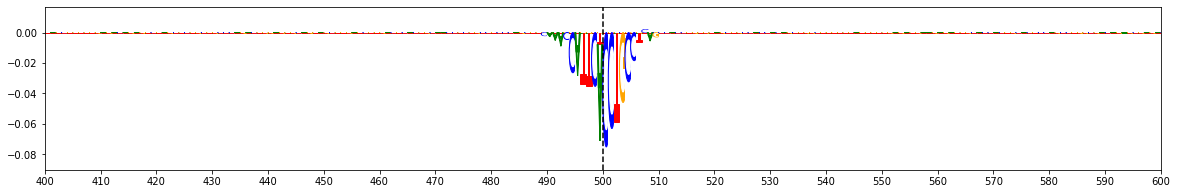



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [19]:
pos_diff_motifs = []

for idx in pos_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], 
          ':', pos_snps.at[idx, 'start'],
          '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', pos_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', pos_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(pos_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', pos_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', pos_snps.at[idx, 'confidence'])
    print()
    print()
    
    if pos_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', pos_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', pos_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if pos_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', pos_snps.at[idx, 'motif_other'])
    else:
        print('Major Allele:', pos_snps.at[idx, 'major'],
              '  ||   Major Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', pos_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(pos_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(pos_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(pos_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(pos_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(pos_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(pos_snps.at[idx, 'delta_pval'], 6))
    print()
    if pos_snps.at[idx, 'effect'] != 'NAN':
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'effect']
                      + '/' + pos_snps.at[idx, 'noneffect']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    else:
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'minor']
                      + '/' + pos_snps.at[idx, 'major']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    pos_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
pos_snps['diff_motif'] = pos_diff_motifs

# Generate Signal Tracks

In [20]:
clust_to_celltype = {1: 'excitatory_neurons', 
                     2: 'inhibitory_neurons',
                     3: 'excitatory_neurons',
                     4: 'excitatory_neurons',
                     5: 'nigral_neurons',
                     6: 'nigral_neurons',
                     7: 'unknown_neurons',
                     8: 'opcs',
                     9: 'opcs',
                     10: 'opcs',
                     11: 'inhibitory_neurons',
                     12: 'inhibitory_neurons',
                     13: 'astrocytes',
                     14: 'astrocytes',
                     15: 'astrocytes',
                     16: 'astrocytes',
                     17: 'astrocytes',
                     18: 'doublets',
                     19: 'oligodendrocytes',
                     20: 'oligodendrocytes',
                     21: 'oligodendrocytes',
                     22: 'oligodendrocytes',
                     23: 'oligodendrocytes',
                     24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

sig_snps = neg_snps.append(pos_snps)
tomtom = ['---' for x in range(len(sig_snps))]
fc_tracks = []
pval_tracks = []
tfactors = ['---' for x in range(len(sig_snps))]
annotations = ['---' for x in range(len(sig_snps))]

for index, row in sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/'+rsid+'.pval.png')
        
sig_snps['tomtom'] = tomtom
sig_snps['fc_track'] = fc_tracks
sig_snps['pval_track'] = pval_tracks
sig_snps['tfactor'] = tfactors
sig_snps['annotation'] = annotations

sig_snps = sig_snps[['chr', 'start', 'end', 'rsid',
                     'effect', 'noneffect', 'direction',
                     'locus_num', 'gwas', 'gwas_pval', 'coloc',
                     'idr_peak', 'ism_pval', 'delta_pval', 'ratio_pval',
                     'confidence', 'motif', 'diff_motif', 'tomtom', 'fc_track',
                     'pval_track', 'tfactor', 'annotation']]

sig_snps.rename(columns = {'ratio_pval': 'explain_pval'}, inplace=True)
sig_snps.sort_values(by=['explain_pval'], ascending=True, inplace=True)

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.04881906509399414
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pyge

INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometrac

INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.09959650039672852
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotti

INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygeno

INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.07220196723937988
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6

INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:

INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.23123693466186523
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spac

INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:

INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INF

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.09316182136535645
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pyge

INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
I

INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometra

INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.06589174270629883
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 

INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
I

INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:py

INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.05138373374938965
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [clu

INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
I

INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO

INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


# Save Significant SNPs

In [21]:
sig_snps.to_csv('/mnt/lab_data3/soumyak/adpd/sig_snps/Cluster'
                + cluster
                + '.'
                + celltype
                + '.snps.csv',
                sep='\t', index=False)

# Final SNP Table <a name='final_table' />

In [22]:
display(sig_snps)

chr      start        end         rsid effect noneffect direction  \
204  chr17   45852666   45852667   rs62054825      G         A         +   
471   chr2   95074354   95074355    rs7585473      T         G         -   
503   chr2  127128581  127128582   rs13025717      T         C         +   
643   chr6   27772520   27772521     rs760587      C         A         -   
360  chr17   46771150   46771151     rs199523      C         A         -   
128  chr17    4901871    4901872   rs79436576      T         C         +   
196  chr17   45848599   45848600   rs62054817      G         A         +   
173  chr17   45783750   45783751   rs62057073      T         C         -   
234  chr17   45897109   45897110   rs80346216      T         G         -   
423  chr19   44890258   44890259  rs117310449      T         C         +   
56   chr11   86103987   86103988    rs1237999      A         G         +   
528   chr3   49007333   49007334    rs6781790      T         C         +   
500   chr2  127117812  127117813    rs3845674      T         G         -   
377  chr17   78414789   78414790    rs3744216      G         A         -   
467  chr19   45326535   45326536     rs344791      C         G         -   
381  chr17   78426790   78426791   rs72914885      C         A         -   
175  chr17   45825432   45825433    rs3885075      G         A         -   
405  chr19   18462023   18462024    rs8103622      T         C         +   
294  chr17   46003041   46003042  17_46003042      G         C         +   
636   chr5  103120549  103120550      rs26523      T         C         -   
534   chr3   52307781   52307782  rs149776414      G         A         -   
668   chr8   22604860   22604861    rs3735901      T         C         -   
283  chr17   45977229   45977230   rs17572495      T         G         +   
370  chr17   75032747   75032748    rs7218004      A         G         +   
437  chr19   44915228   44915229   rs12691088      A         G         +   
476   chr2   95297493   95297494    rs2248415      G         C         +   
216  chr17   45882956   45882957   rs56365901      G         A         -   
197  chr17   45848689   45848690   rs62054818      C         A         -   
228  chr17   45895754   45895755  rs111972148      G         C         +   
259  chr17   45940574   45940575   rs62061732      T         G         -   
316  chr17   46059822   46059823   rs55714296      T         A         -   

     locus_num                      gwas      gwas_pval  coloc  idr_peak  \
204         54           23andme_PD_hg38   1.247000e-22   True      True   
471         85             Nalls_23andMe   3.673230e-02  False      True   
503         77    Alzheimers_Jansen_2018   9.125833e-17  False     False   
643        110             Nalls_23andMe   6.436710e-06  False      True   
360         54           23andme_PD_hg38   9.492900e-14   True      True   
128         55   Alzheimers_Lambert_2013   4.789000e-05   True     False   
196         54           23andme_PD_hg38   1.136600e-22   True      True   
173         54           23andme_PD_hg38   2.157620e-22   True      True   
234         54           23andme_PD_hg38   3.938720e-22   True     False   
423         71    Alzheimers_Jansen_2018   7.042756e-94   True      True   
56          16    Alzheimers_Jansen_2018   7.143148e-16  False      True   
528         92  Chang_23andMe_Parkinsons   2.349340e-03  False      True   
500         77    Alzheimers_Jansen_2018   3.372541e-12  False      True   
377         62             Nalls_23andMe   5.922390e-02  False      True   
467         71    Alzheimers_Jansen_2018   1.215671e-04   True      True   
381         62             Nalls_23andMe   4.467170e-02  False      True   
175         54           23andme_PD_hg38   1.338240e-22   True      True   
405         69    Alzheimers_Kunkle_2019   1.279000e-05   True      True   
294         54           23andme_PD_hg38   2.177860e-22   True      True   
636        104             Nalls_23andMe   1.084830e-0